# Clustering Notes

The following notes follow along this blog [post](https://towardsdatascience.com/an-introduction-to-clustering-algorithms-in-python-123438574097). Clustering methods all use a central idea of a **distance** or **metric** defined by a function $d(i,j)$. It is often the Euclidean distance.

## DBSCAN

### Concepts

Consider a set of points in some space to be clustered. Let $X = \{x_1, ..., x_n\}$, a set of $n$ objects, $\epsilon$ be a parameter specifying a radius of a neighborhood with respect to some point. Points in DBSCAN fall into 3 categories:
- a point $p$ is a **core point** if there are at least a minimum number of points within $\epsilon$ of it, including itself
- a point $q$ is **directly reachable** from point $p$ if $q$ is within distance $\epsilon$, but only if $p$ is a core point
- a point $q$ is **reachable** form $p$ if there is a path $p_1, ..., p_n$ with $p_1 = p$ and $p_n = q$ where each $p_{i+1}$ is directly reachable from $p_i$. This implies that the initial point and all points on the path must be core points, with the potential exception of $q$
- all points not reachable from any other point are **outliers** or **noise points**

Reachability is not a symmetric relation, so another concept of connection is required for the extent of clusters: 
- two points are **density-connected** if there is a point $o$ such that both $p$ and $q$ are reachable from $o$


Clusters satisfy two properties:
- all points within a cluster are mutually density-connected
- if a point is density-reachable from some point of the cluster, it is part of the cluster as well

### Steps

0. Choose minimum points $m_{pts}$ threshold and $\epsilon$

1. Find the points in the $\epsilon$ neighborhood of every point, and identify the core points with more than $m_{pts}$ neighbors
2. Find the connected components of *core* points on the neighbor graph, ignoring all non-core points
3. Assign each non-core point to a nearby cluster if the cluster is an $\epsilon$ neighbor, otherwise assign it to noise

### Optimization Criterion

For any possible clustering $C = \{C_1, ..., C_t\}$ out of the set of all clusterings $\mathcal{C}$, DBSCAN minimizes the number of clusters such that every pair of points, $p, q$ in a cluster is density-reachable.

$$\underset{C \subset\mathcal{C}, d_{db}(p, q) \le \epsilon \forall p, q \in C_i \forall C_i \in C}\min |C|$$

## HDBSCAN

This is a hierarchical extension of DBSCAN. For a chosen $m_{pts}$

### Concepts

#### Core Distance $d_{core}(x_p)$

 applies to object $x_p \in X$, with respect to $m_{pts}$, is defined as the distance from $x_p$ to its $m_{pts}$-nearest neighbor, including itself


#### $\epsilon$-Core Object

Any object $x_p \in X$ is where the following holds:
$$d_{core}(x_p) \le \epsilon$$ 

#### Mutual Reachability Distance $d_{mreach}(x_p, x_q)$

is defined as $$d_{mreach}(x_p, x_q) \equiv\max\{d_{core}(x_p), d_{core}(x_q), d(x_p, x_q) \}$$

#### Mutual Reachability Graph $G_{m_{pts}}$

The *complete* graph in which the objects of $X$ are vertices and the weight of each edge is the mutual reachability distance (wrt $m_{pts}$) between the respective pair of objects. 


#### Subgraphs of $G_{m_{pts}}$ and Hierarchies

If we take a subgraph $G_{m_{pts}, \epsilon}$ obtained by removing all edges from $G_{m_{pts}}$ with weights greater than $\epsilon$, then the connected components are the $\epsilon$-core objects in the DBSCAN clusters, and remaining objects noise. Thus, DBSCAN partitions for $\epsilon \in [0, \infty)$ can be produced in a hierarchical way: at 0 we have the finest clusters, or leaves of a dendrogram, while at higher values, we approach the root of the dendrogram.

### Steps

#### Core Algorithm 

1. Compute core distance wrt $m_{pts}$ for all data objects in $X$
2. Compute minimum spanning tree (MST) of $G_{m_{pts}}$, the mutual reachability graph
3. Extend the MST to obtain $MST_{ext}$ by adding for each vertex, a "self edge" with the core distance of the corresponding object as weight
4. Extract the HDBSCAN hierarchy as a dendrogram from $MST_{ext}$
    - 4.1 For the root of the tree, assign all objects the same label
    - 4.2 Iteratively remove all edges from the $MST_{ext}$ in decreasing order of weight, with ties being removed simultaenously
        - 4.2.1 Before each removal, set the dendrogram scale value of the current hierarchical level as the weight of the edge(s) to be removed
        - 4.2.2 After each removal, assign labels to connected component(s) that contain the end vertices of removed edges, a new cluster label to a component if it still has at least one edge, else noise
            
#### Customizable Cluster Processing Final Step 

When reaching a lower $\epsilon$ level in the tree, we must consider what happens to the clusters. We can define a separate minimum cluster size which can be applied to the following:
- if **all** cluster's subcomponents are spurious, it **disappears**
- if **only one** of cluster's subcomponents is *not spurious*, keep original label, ie **cluster shrinkage**
- if **two or more** of cluster's subcomponents are *not spurious*, **"true" cluster split**

### Optimal Clustering

#### Cluster Stability

When increasing the density threshold, we can see prominent clusters remain and shrink or split while others disappear. A cluster can be seen as a set of points that whose density $f(x)$, exceed a threshold, ie.  $\lambda = 1/{\epsilon}$. For a density contour cluster $C_i$ that appears at density level $\lambda_{min}(C_i)$, we can formalize its stability by defining its **excess of mass** as:

$$E(C_i) = \int_{x \in C_{i}}\Big( f(x) - \lambda_{min}(C_i)\Big)dx$$


This exhibits monotonic behavior along branches of the dendrogram, so it cannot be used to compare stabilities of nested clusters. Instead, we can define the **relative excess of mass**:

$$E_R(C_i) = \int_{x \in C_{i}}\Big( \lambda_{max}(x, C_i) - \lambda_{min}(C_i)\Big)dx$$


where $\lambda_{max}(C_i)$ is the density level at which $C_i$ is split or disappears, and $\lambda_{max}(x, C_i) = \min\{f(x), \lambda_{max}(C_i)\}$ 


For an HDBSCAN hierarchy, where we have finite data set $X$, cluster labels, and desnity thresholds associated with each hierarchical level, we can adapt the previous expression to define the **stability** of a cluster $C_i$ as:

$$ S(C_i) = \sum_{x_j \in C_i} \Big( \lambda_{max}(x, C_i) - \lambda_{min}(C_i)\Big) = \sum_{x_j \in C_i} \Big(\frac{1}{\epsilon_{min}(x_j, C_i)} - \frac{1}{\epsilon_{max}(C_i)}\Big)$$


where $\lambda_{min}(C_i)$ is the minimum density level at which $C_i$ exists, $\lambda_{max}(x_j, C_i)$ is the density level beyond which object $x_j$ no longer belongs to cluster $C_i$ and $\epsilon_{max}(C_i)$ and $\epsilon_{min}(x_j, C_i)$ are the corresponding values for the threshold $\epsilon$. 

#### Cluster Selection Algorithm

With the notion of cluster stability developed, we can have extraction of the most prominent clusters formulated as an optimization problem of maximizing cluster stabilities subject to constraints:

$$\underset{\delta_2, ..., \delta_{\kappa}}\max J = \sum^\kappa_{i=2}\delta_iS(C_i)$$

$$\text{subject to} \begin{cases}
                    \delta_i \in \{0,1\}, i=2,...,\kappa \\                    
                    \sum_{j \in I_h} \delta_j = 1, \forall h \in L\\
                    \end{cases}$$

where $\delta_i$ indicates if cluster $i$ is in the flat solution, $L = \{h | C_h \text{is a leaf cluster}\}$ is the set of indices of leaf clusters, and $I_h = \{j | j \ne 1 \text{ and }C_j \text{ is an ascendant of } C_h\}$, the set of indices of all clusters on the path from $C_h$ (included) to the root (excluded). The constraints prevent nested clusters on the same path from being selected at the same time.



Selecting the clusters requires bottom up processing of nodes excluding the root, starting with the leaves, deciding whether to keep node $C_i$ or a best so far selection of clusters in its subtrees. In the process, the total stability, $\hat{S}(C_i)$ is updated:

$$\hat{S}(C_i) = \begin{cases}
                S(C_i), &\text{if } C_i \text{ is a leaf node}\\
                \max\{S(C_i), \hat{S}(C_{i_l}) + \hat{S}(C_{i_r}) &\text{if } C_i \text{ is an internal node}\\
                \end{cases}
                $$


##### Steps

1. Initialize $\delta_2 = ... \delta_\kappa = 1$ and for all leaf nodes, set $\hat{S}(C_h) = S(C_h)$
2. Starting from the deepest levels, do bottom-up (excluding root):
    - 2.1 If $S(C_i) < \hat{S}(C_{i_r}) + \hat{S}(C_{i_l})$, set $\hat{S}(C_i) = \hat{S}(C_{i_l}) + \hat{S}(C_{i_r})$ and set $\delta_i=0$ 
    - 2.2 Else, set $\hat{S}(C_i) = S(C_i)$ and set $\delta_{(.)} = 0$ for all clusters in $C_i$'s subtrees.

### Implementation

Hierarchical clustering can typically be slow but thanks to parallelization, can be sped up via GPUs. Nvidia's [blog](https://developer.nvidia.com/blog/faster-hdbscan-soft-clustering-with-rapids-cuml/) entry, *Faster HDBSCAN Soft Clustering with RAPIDS cuML*, shows comparisons with multiple methods on datasets of varying sizes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

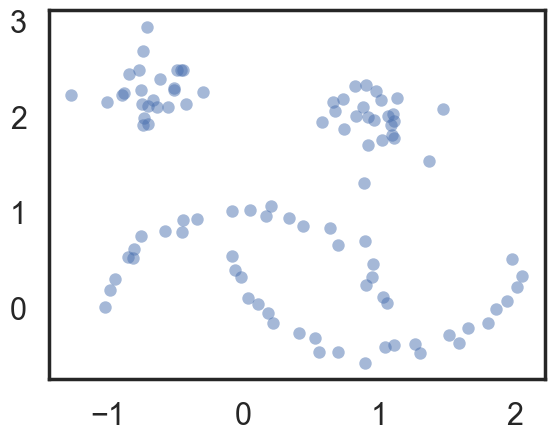

In [2]:
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data = np.vstack([moons, blobs])
plt.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)

In [4]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)

HDBSCAN(gen_min_span_tree=True)

<Axes: >

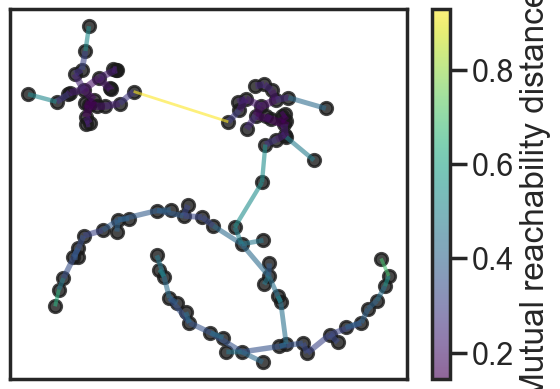

In [5]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<Axes: ylabel='distance'>

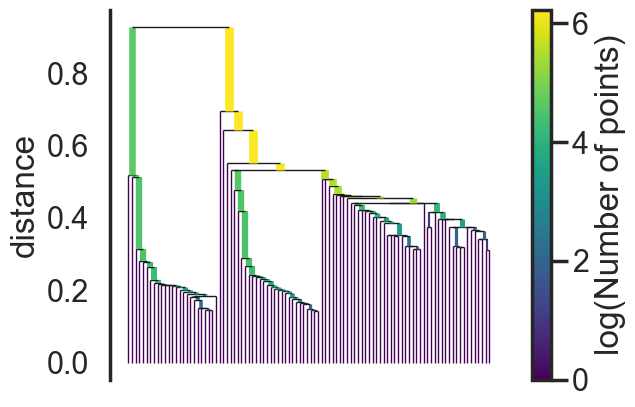

In [6]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<Axes: ylabel='$\\lambda$ value'>

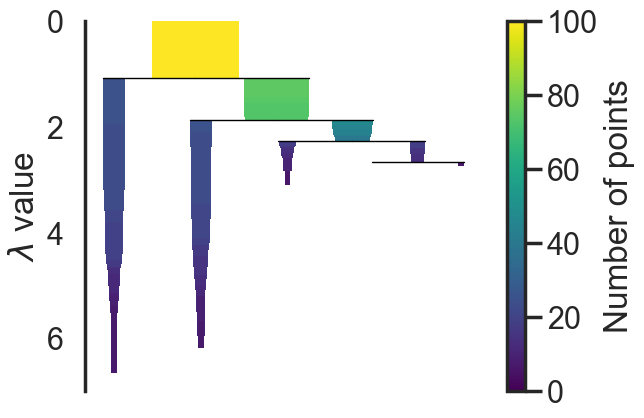

In [7]:
clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

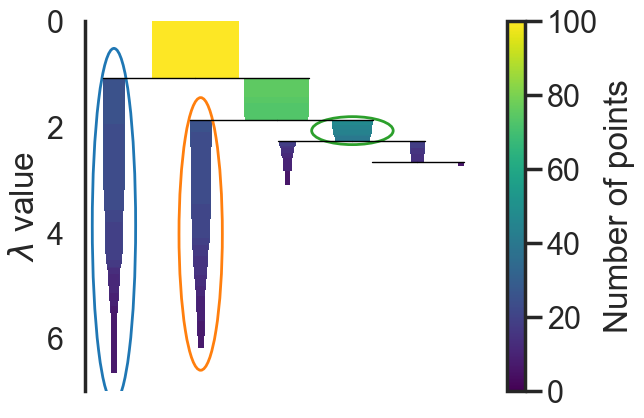

In [8]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

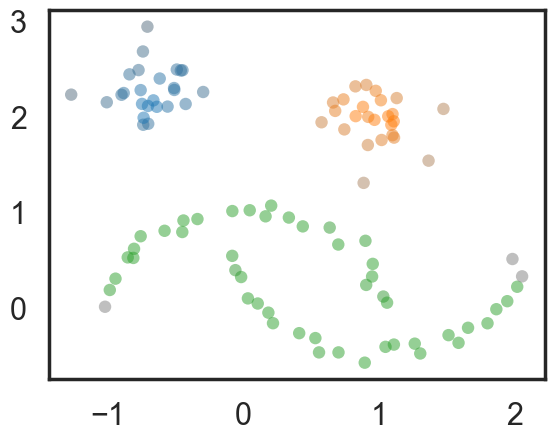

In [9]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

### Soft Clustering for HDBSCAN

#### Concept

- Hard clustering assigns a single cluster label or noise
- Soft clustering assigns a vector of probabilities

#### Instructional Implementation

In [1]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl

from scipy.spatial.distance import cdist

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

plot_kwds={'alpha':0.25, 's':60, 'linewidths':0}
palette = sns.color_palette('deep', 12)

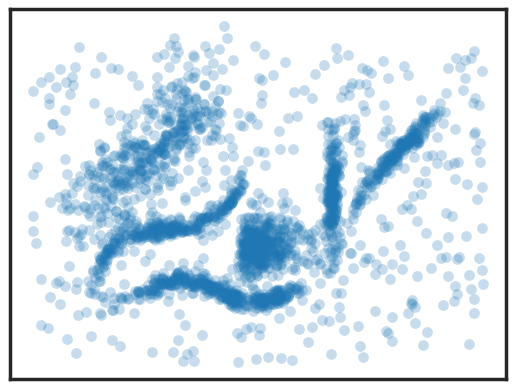

In [2]:
data = np.load('clusterable_data.npy')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(data.T[0], data.T[1], **plot_kwds)
ax.set_xticks([])
ax.set_yticks([]);

In [6]:
len(data)

2309

In [4]:
# build a clustering object to fit the data
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
clusterer.labels_

array([ 5,  5,  5, ..., -1, -1,  5], dtype=int64)

In [7]:
len(clusterer.labels_)

2309

In [5]:
clusterer.probabilities_

array([1.        , 0.85883269, 0.90828071, ..., 0.        , 0.        ,
       1.        ])

In [14]:
clusterer.probabilities_

array([1.        , 0.85883269, 0.90828071, ..., 0.        , 0.        ,
       1.        ])

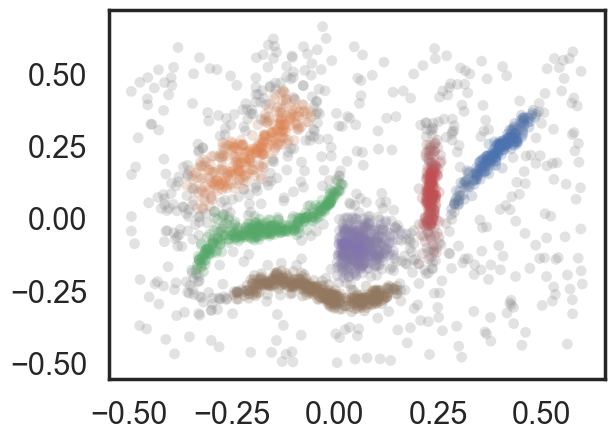

In [16]:
# visualize clustering using scores as saturation
pal = sns.color_palette('deep', 8)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,
                                                            clusterer.probabilities_)]
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)

##### Distance Based Membership

This takes advantage of features to examine clustering further, as pointed out in these [docs](https://hdbscan.readthedocs.io/en/latest/advanced_hdbscan.html#). In particular, we use the [`CondensedTree`](https://github.com/scikit-learn-contrib/hdbscan/blob/master/hdbscan/plots.py#L54) object, obtained via `clusterer. which is a dendrogram, or family tree of various clusters.


- `_raw_tree` is the tree in the form of a numpy [recarray](https://numpy.org/doc/stable/reference/generated/numpy.recarray.html) allowing lookup based on field names where each row represents an edge between a parent and child clusters:
    - **parent**: id of parent cluster
    - **child**: id of child cluster
    - **lambda_val**: inverse distance, aka density at which edge forms
    - **child_size**: number of points in the child cluster

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_16588\4108267181.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data.T[0][c_exemplars], data.T[1][c_exemplars], c=palette[i], **plot_kwds)


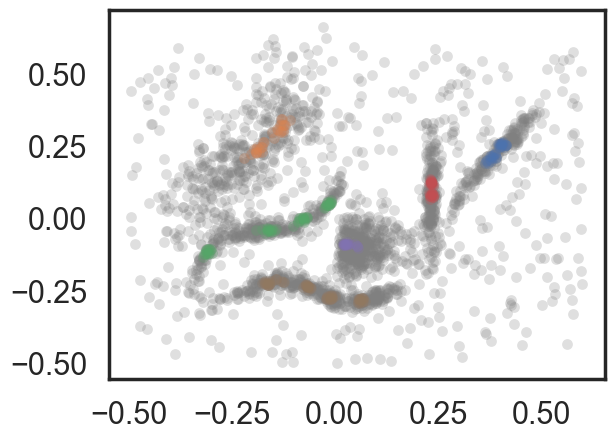

In [94]:
def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    clusterer_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(clusterer_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) &
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype('int32')

tree = clusterer.condensed_tree_
plt.scatter(data.T[0], data.T[1], c='grey', **plot_kwds)
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    plt.scatter(data.T[0][c_exemplars], data.T[1][c_exemplars], c=palette[i], **plot_kwds)

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_16588\1075745609.py:16: RuntimeWarning: divide by zero encountered in divide
  result = 1./dist_vector(point, exemplar_dict, data)


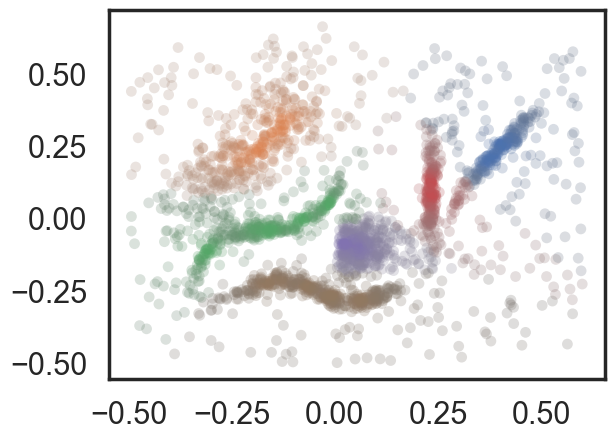

In [111]:
def min_dist_to_exemplar(point, cluster_exemplars, data):
    dists = cdist([data[point]], data[cluster_exemplars.astype(np.int32)])
    return dists.min()

def dist_vector(point, exemplar_dict, data):
    result = {}
    for cluster in exemplar_dict:
        result[cluster] = min_dist_to_exemplar(point, exemplar_dict[cluster], data)
    return np.array(list(result.values()))

def dist_membership_vector(point, exemplar_dict, data, softmax=False):
    if softmax:
        result = np.exp(1./dist_vector(point, exemplar_dict, data))
        result[~np.isfinite(result)] = np.finfo(np.double).max
    else:
        result = 1./dist_vector(point, exemplar_dict, data)
        result[~np.isfinite(result)] = np.finfo(np.double).max
    result /= result.sum()
    return result


exemplar_dict = {c:exemplars(c, tree) for c in tree._select_clusters()}
colors = np.empty((data.shape[0], 3))
for x in range(data.shape[0]):
    membership_vector = dist_membership_vector(x, exemplar_dict, data)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds);

##### Outlier Based Membership

- these are density-based memberships using cluster persistence as a baseline of comparison
- GLOSH algorithm compares cluster persistence with how long a point stayed in the cluster
- we can compare cluster persistence with the *merge height* of the point with a fixed cluster in the dendrogram
    - merge height represents the disimilarity between two clusters
    - we can do that with multiple clusters to form a vector which can be normalized into memership scores

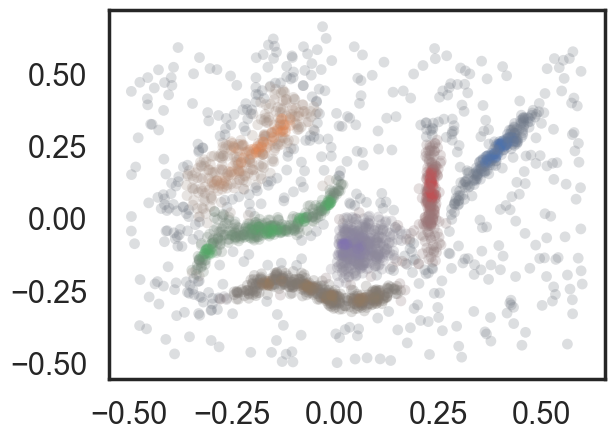

In [126]:
def max_lambda_val(cluster, tree):
    cluster_tree = tree[tree['child_size'] > 1]
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster)
    max_lambda = 0.0
    for leaf in leaves:
        max_lambda = max(max_lambda,
                         tree['lambda_val'][tree['parent'] == leaf].max())
    return max_lambda

def points_in_cluster(cluster, tree):
    leaves = hdbscan.plots._recurse_leaf_dfs(tree, cluster)
    return leaves

def merge_height(point, cluster, tree, point_dict):
    cluster_row = tree[tree['child'] == cluster]
    cluster_height = cluster_row['lambda_val'][0]
    if point in point_dict[cluster]:
        merge_row = tree[tree['child'] == float(point)][0]
        return merge_row['lambda_val']
        
    else:
        while point not in point_dict[cluster]:
            parent_row = tree[tree['child'] == cluster]
            cluster = parent_row['parent'].astype(np.float64)[0]
        for row in tree[tree['parent'] == cluster]:
            child_cluster = float(row['child'])
            if child_cluster == point:
                return row['lambda_val']
            if child_cluster in point_dict and point in point_dict[child_cluster]:
                return row['lambda_val']
            
def per_cluster_scores(point, cluster_ids, tree, max_lambda_dict, point_dict):
    result = {}
    point_row = tree[tree['child'] == point]
    point_cluster = float(point_row[0]['parent'])
    max_lambda = max_lambda_dict[point_cluster] + 1e-8 # avoid zero lambda vals in odd cases
    
    for c in cluster_ids:
        height = merge_height(point, c, tree, point_dict)
        result[c] = (max_lambda / (max_lambda - height))
    return result

def outlier_membership_vector(point, cluster_ids, tree,
                              max_lambda_dict, point_dict, softmax=True):
    if softmax:
        result = np.exp(np.array(list(per_cluster_scores(point,
                                                         cluster_ids,
                                                         tree,
                                                         max_lambda_dict,
                                                         point_dict
                                                         ).values())))
        result[~np.isfinite(result)] = np.finfo(np.double).max
    else:
        result = np.array(list(per_cluster_scores(point,
                                                  cluster_ids,
                                                  tree,
                                                  max_lambda_dict,
                                                  point_dict
                                                 ).values()))
        result /= result.sum()
    return result

cluster_ids = tree._select_clusters()
raw_tree = tree._raw_tree
all_possible_clusters = np.arange(data.shape[0], raw_tree['parent'].max() + 1).astype(np.float64)
max_lambda_dict = {c:max_lambda_val(c, raw_tree) for c in all_possible_clusters}
point_dict = {c:set(points_in_cluster(c, raw_tree)) for c in all_possible_clusters}
colors = np.empty((data.shape[0], 3))
for x in range(data.shape[0]):
    membership_vector = outlier_membership_vector(x, cluster_ids, raw_tree,
                                                  max_lambda_dict, point_dict, False)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds);

##### Middle Way

To combine distance and membership approaches we can:
- view membership vectors as probability distributions
- combining them can be achieved via Bayes' rule

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_16588\1075745609.py:16: RuntimeWarning: divide by zero encountered in divide
  result = 1./dist_vector(point, exemplar_dict, data)


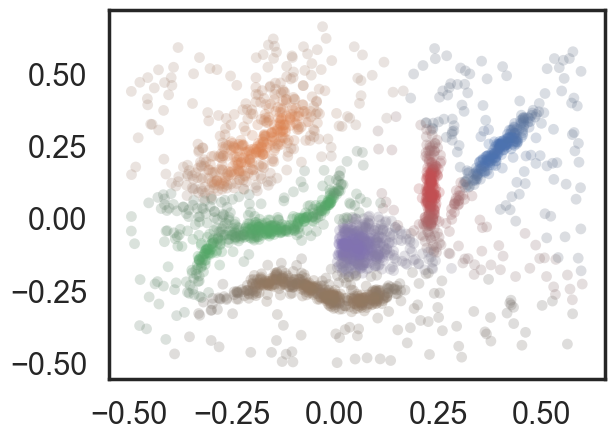

In [129]:
def combined_membership_vector(point, data, tree, exemplar_dict, cluster_ids,
                    max_lambda_dict, point_dict, softmax=False):
    raw_tree = tree._raw_tree
    dist_vec = dist_membership_vector(point, exemplar_dict, data, softmax)
    outl_vec = outlier_membership_vector(point, cluster_ids, raw_tree,
                                         max_lambda_dict, point_dict, softmax)
    result = dist_vec * outl_vec
    result /= result.sum()
    return result

colors = np.empty((data.shape[0], 3))
for x in range(data.shape[0]):
    membership_vector = combined_membership_vector(x, data, tree, exemplar_dict, cluster_ids,
                                                   max_lambda_dict, point_dict, False)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds);


##### Converting a Conditional Probability

The previous computation was the probability vector that a point is in each cluster, given that the point is in a cluster. To convert the conditional probability to a joint one, we need to:
- multiply it by the probability that that there is a cluster to which the point belongs
- this can be estimated from the merge height and comparing it with the max density
    - this should result in a number between 0 and 1
    
- plotting can show the $ \text{argmax}$ cluster and the corresponding color

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_16588\1075745609.py:16: RuntimeWarning: divide by zero encountered in divide
  result = 1./dist_vector(point, exemplar_dict, data)


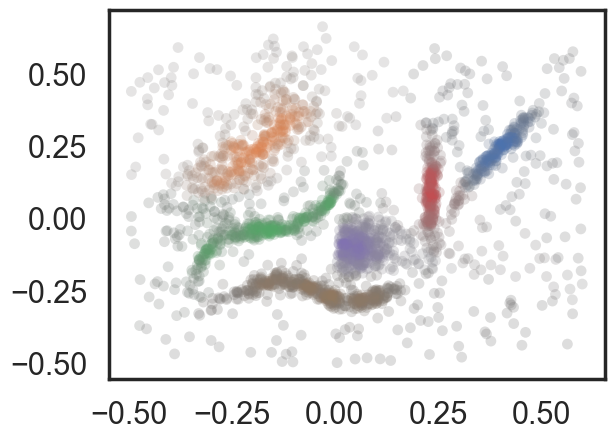

In [130]:
def prob_in_some_cluster(point, tree, cluster_ids, point_dict, max_lambda_dict):
    heights = []
    for cluster in cluster_ids:
        heights.append(merge_height(point, cluster, tree._raw_tree, point_dict))
    height = max(heights)
    nearest_cluster = cluster_ids[np.argmax(heights)]
    max_lambda = max_lambda_dict[nearest_cluster]
    return height / max_lambda

colors = np.empty((data.shape[0], 3))
for x in range(data.shape[0]):
    membership_vector = combined_membership_vector(x, data, tree, exemplar_dict, cluster_ids,
                                                   max_lambda_dict, point_dict, False)
    membership_vector *= prob_in_some_cluster(x, tree, cluster_ids, point_dict, max_lambda_dict)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds);


#### Soft Clustering in Practice

What are the general steps involved in performing a soft clustering analysis?

1. dimensionality reduction as a prerequisite to 2D visualization:
    - PCA
    - TSNE
    - UMAP    
2. visualization of raw data
3. soft clustering via HDBSCAN
4. visualization of cluster membership
    - hard clustering color coding
    - soft clustering color saturation   
5. quantitative analysis of cluster membership probabilities

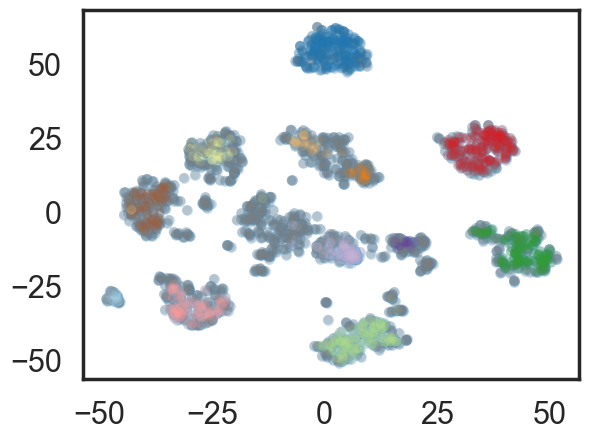

In [131]:
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hdbscan

# loading raw data, 8x8 gray scale of handwritten digits, plotting low dimensional projection
digits = datasets.load_digits()
data = digits.data
projection = TSNE().fit_transform(data)
plt.scatter(*projection.T, **plot_kwds)


# setting up a clustering object, fitting and clustering the data 
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True).fit(data)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

Some of the data is noisy, so we can examine the noisy ones more through soft clustering.

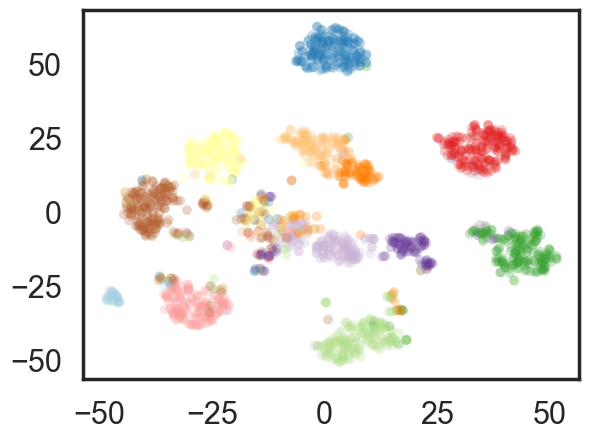

In [136]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

We can show uncertainty by coupling probability with desaturation of color. The higher the probability, the more saturated or pure the color. The lower the probability, the more gray it will be. Here we can see that desaturation is a harsh treatment with lots of gray, and that a lower limit may be more visually meaningful.

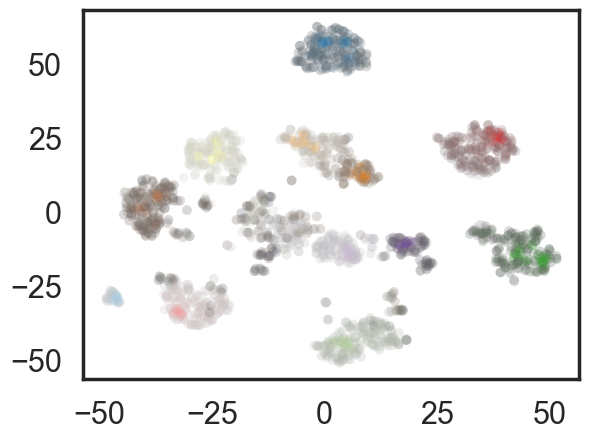

In [143]:
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [sns.desaturate(color_palette[np.argmax(x)], np.max(x))
                  for x in soft_clusters]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

One question to investigate is what points have high likelihoods for two clusters and low for the others. It's worthwhile to note that the probabilities are joint ones, and that points have a probability of not being in a cluster. 

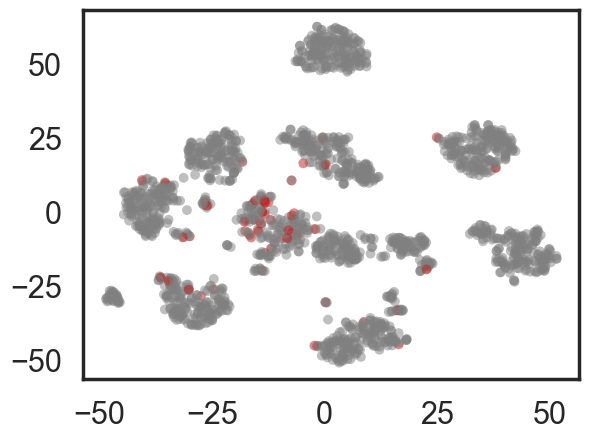

In [158]:
def top_two_probs_diff(probs):
    sorted_probs = np.sort(probs)
    return sorted_probs[-1] - sorted_probs[-2]

# Compute the differences between the top two probabilities
diffs = np.array([top_two_probs_diff(x) for x in soft_clusters])
# Select out the indices that have a small difference, and a larger total probability, extract from tuple form
mixed_points = np.where((diffs < 0.001)  & (np.sum(soft_clusters, axis=1) > 0.5))[0]

colors = [(0.75, 0.1, 0.1) if x in mixed_points
          else (0.5, 0.5, 0.5) for x in range(data.shape[0])]
plt.scatter(*projection.T, s=50, linewidth=0, c=colors, alpha=0.5)

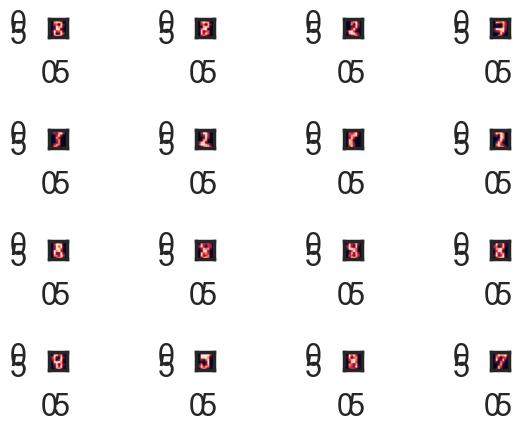

In [162]:
fig = plt.figure()
for i, image in enumerate(digits.images[mixed_points][:16]):
    ax = fig.add_subplot(4,4,i+1)
    ax.imshow(image)
plt.tight_layout()

(array([ 36.,  47.,  92., 171., 332., 229., 181., 297., 153., 259.]),
 array([0.58730357, 0.62857321, 0.66984285, 0.7111125 , 0.75238214,
        0.79365178, 0.83492143, 0.87619107, 0.91746071, 0.95873036,
        1.        ]),
 <BarContainer object of 10 artists>)

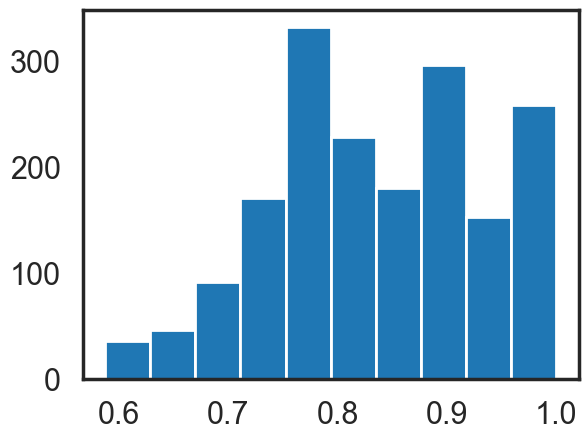

In [152]:
plt.hist(np.sum(soft_clusters, axis=1))

## K-means Clustering

### Description

Given a set of observations $(x_1, x_2, ..., x_n)$ in a $d$-dimensional vector space, k-means clustering partitions the $n$ observations into $k$ sets, $\textbf{S} = \{S_1, S_2, ... S_k\}$. The goal is to minimize the variance within each cluster:

$$\underset{\textbf{S}}{\arg\min} \sum^k_{i=1} \sum_{x\in S_i} ||x - \mu_i||^2 = \underset{\textbf{S}}{\arg\min}\sum^k_{i=1}|S_i|\text{Var}S_i$$

where $\mu_i$ is the mean or centroid of the points in $S_i$.

### Steps

#### Initialization

First choose $k$ and initialize randomly chosen $k$ centroids at $t = 0$, the initial step.

#### Assignment

Assign each observation to the cluster with the nearest mean, in terms of Euclidean distance. Each set is thus:

$$S^{(t)}_i = \big\{x_p : ||x_p - m_i^{(t)}||^2 \le ||x_p - m_j^{(t)}||^2 \forall j, 1 \le j \le k \big\}$$ 

#### Update

After assignment, update to find the new means for the next iteration, $t + 1$:

$$ m_i^{t + 1} = \frac{1}{|S_i^{(t)}|}\sum_{x_j \in S_i^{(t)}}x_j$$

The number of computations scales with the number of samples $n$, the number of centers $k$, the number of dimensions $d$ and the number of iterations $i$, for $O(nkdi)$

### Creating the Dataset

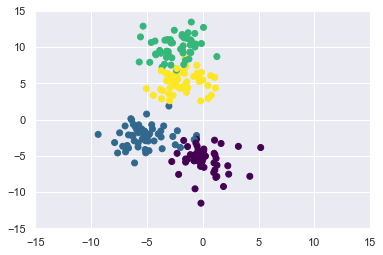

In [1]:
# import statements
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set('notebook')
# Generate and plot data with predetermined model and classes
X, y = make_blobs(n_samples=200, n_features=2, centers=4,
                  cluster_std=1.6, random_state=50)

plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

In [2]:
Y = np.zeros((200, 2))
Y[:,0] = y
Y

array([[2., 0.],
       [0., 0.],
       [3., 0.],
       [3., 0.],
       [1., 0.],
       [0., 0.],
       [2., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [2., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [3., 0.],
       [2., 0.],
       [2., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [3., 0.],
       [2., 0.],
       [2., 0.],
       [2., 0.],
       [3., 0.],
       [2., 0.],
       [1., 0.],
       [3., 0.],
       [2., 0.],
       [2., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [3., 0.],
       [3., 0.],
       [2., 0.],
       [1., 0.],
       [3., 0.],
       [3., 0.],
       [0., 0.],
       [0., 0.],
       [2., 0.],
       [3., 0.],
       [3., 0.],
       [2., 0.],
       [0., 0.],
       [1., 0.],
       [3., 0.],
       [2., 0.],
       [3., 0.],
       [3., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.

In [3]:
from sklearn.cluster import KMeans

[[-5.56465793 -2.34988939]
 [-1.92101646  5.21673484]
 [ 0.05161133 -5.35489826]
 [-2.40167949 10.17352695]]


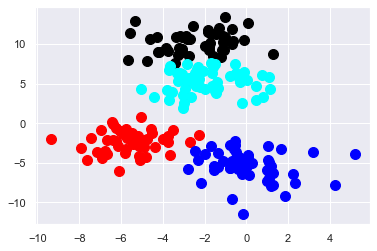

In [4]:
n_clusters=4

# Fit and predict clusters
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
print(kmeans.cluster_centers_)
y_km = kmeans.fit_predict(X)

# Plot predictions, one class at a time
for i, c in enumerate(['red', 'black', 'blue', 'cyan']):
    plt.scatter(X[y_km ==i,0], X[y_km == i,1], s=100, c=c)
plt.show()

## Hierarchical Clustering 

[Hierarchical clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) involves starting with treating each observation as a set, and then at the following step, creating a new cluster from the two "nearest" clusters, according to the defined distance metric. There are multiple ways the idea of a distance metric can extend to clusters. Some common choices include the average, closest members, or farthest nembers. 

In [5]:
# import hierarchical clustering libraries
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree
%load_ext autoreload
%autoreload 2
sns.set()
data = [[i] for i in [-30, 4, 1, 2, 5, 6, 10, 50, 75, 100]]

In [6]:
def llf(id):
    return str(id)

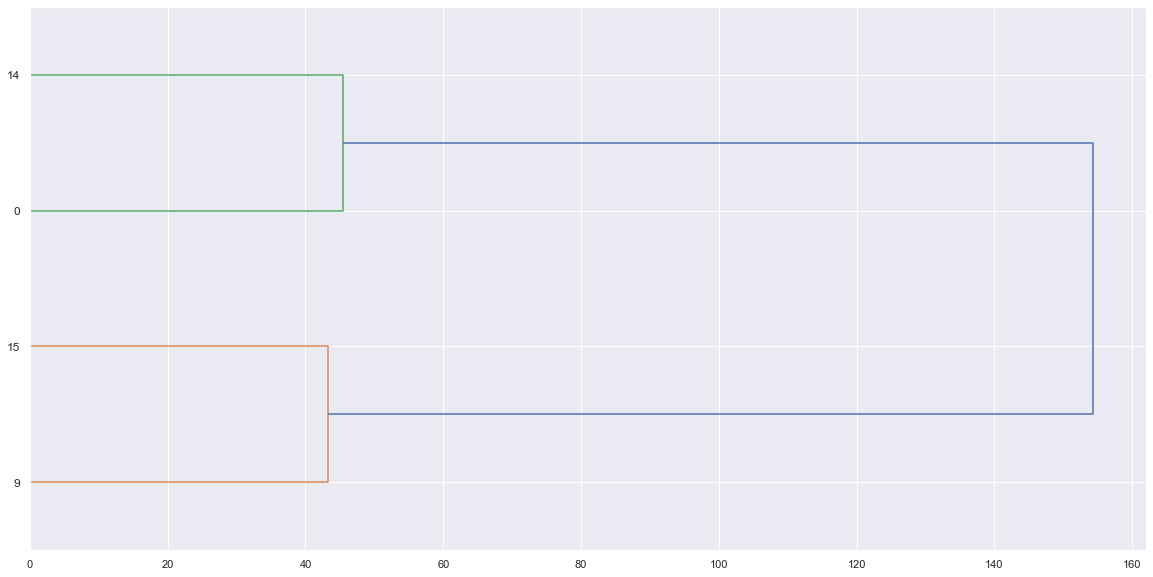

In [10]:
Z = linkage(data, 'ward')
fig = plt.figure(figsize=(20, 10))
dn_truncated = dendrogram(Z, orientation='right', p=4, truncate_mode='lastp', leaf_label_func=llf)

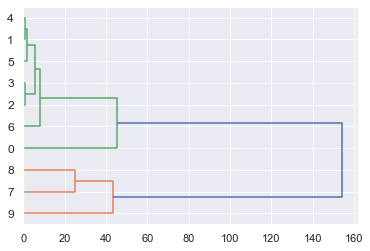

In [14]:
dn = dendrogram(Z, orientation='right', p=4, truncate_mode=None, leaf_label_func=llf)

In [11]:
dn_truncated

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0]],
 'dcoord': [[0.0, 43.30127018922193, 43.30127018922193, 0.0],
  [0.0, 45.389321169086415, 45.389321169086415, 0.0],
  [43.30127018922193,
   154.2898015331631,
   154.2898015331631,
   45.389321169086415]],
 'ivl': ['9', '15', '0', '14'],
 'leaves': [9, 15, 0, 14],
 'color_list': ['C1', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C2', 'C2'],
 'traversal': [18, 16, 9, 15, 17, 0, 14]}

In [15]:
dn['icoord']

[[15.0, 15.0, 25.0, 25.0],
 [5.0, 5.0, 20.0, 20.0],
 [55.0, 55.0, 65.0, 65.0],
 [85.0, 85.0, 95.0, 95.0],
 [75.0, 75.0, 90.0, 90.0],
 [60.0, 60.0, 82.5, 82.5],
 [45.0, 45.0, 71.25, 71.25],
 [35.0, 35.0, 58.125, 58.125],
 [12.5, 12.5, 46.5625, 46.5625]]

In [16]:
dn['dcoord']

[[0.0, 25.0, 25.0, 0.0],
 [0.0, 43.30127018922193, 43.30127018922193, 25.0],
 [0.0, 1.0, 1.0, 0.0],
 [0.0, 1.0, 1.0, 0.0],
 [0.0, 1.7320508075688772, 1.7320508075688772, 1.0],
 [1.0, 5.422176684690383, 5.422176684690383, 1.7320508075688772],
 [0.0, 8.262364471909155, 8.262364471909155, 5.422176684690383],
 [0.0, 45.389321169086415, 45.389321169086415, 8.262364471909155],
 [43.30127018922193, 154.2898015331631, 154.2898015331631, 45.389321169086415]]

In [17]:
dn_truncated['icoord']

[[5.0, 5.0, 15.0, 15.0], [25.0, 25.0, 35.0, 35.0], [10.0, 10.0, 30.0, 30.0]]

In [18]:
dn_truncated['dcoord']

[[0.0, 43.30127018922193, 43.30127018922193, 0.0],
 [0.0, 45.389321169086415, 45.389321169086415, 0.0],
 [43.30127018922193, 154.2898015331631, 154.2898015331631, 45.389321169086415]]

In [19]:
k = 4
for i in zip(dn['icoord'][k], dn['dcoord'][k]):
    print(i)

(75.0, 0.0)
(75.0, 1.7320508075688772)
(90.0, 1.7320508075688772)
(90.0, 1.0)


### Linkage Matrix


Full documentation for `Scipy`'s implementation is found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html). The original observations are treated as $n$ clusters. There are $n-1$ new clusters created beyond these total, with indices ranging from $n+1$ to $2n-1$, ordered by the inter-cluster distance. Each of thse new clusters is made from two other clusters. The $n-1 \times 4$ linkage matrix $Z$ encodes information about the new clusters in the following manner: Each row $i$ (keeping in mind zero indexing) describes the $(i+1)$th cluster by listing the indices of the two source clusters, the inter-cluster distance between these two clusters, and finally, the number of members of the new cluster.

In [20]:
Z

array([[  2.        ,   3.        ,   1.        ,   2.        ],
       [  1.        ,   4.        ,   1.        ,   2.        ],
       [  5.        ,  11.        ,   1.73205081,   3.        ],
       [ 10.        ,  12.        ,   5.42217668,   5.        ],
       [  6.        ,  13.        ,   8.26236447,   6.        ],
       [  7.        ,   8.        ,  25.        ,   2.        ],
       [  9.        ,  15.        ,  43.30127019,   3.        ],
       [  0.        ,  14.        ,  45.38932117,   7.        ],
       [ 16.        ,  17.        , 154.28980153,  10.        ]])

In [21]:
plt.show()


### Converting the Linkage Matrix to Tree

In [22]:
to_tree(Z)
rootnode, nodelist = to_tree(Z, rd=True)
rootnode


In [23]:
rootnode.get_right().pre_order()

[0, 6, 2, 3, 5, 1, 4]

In [24]:
len(nodelist)

19

In [25]:
nodelist[4].pre_order()

[4]

### Visualization with Plotly

In [34]:
p =6

In [35]:
np.array(data)

array([[-30],
       [  4],
       [  1],
       [  2],
       [  5],
       [  6],
       [ 10],
       [ 50],
       [ 75],
       [100]])

In [36]:
n = len(data)

In [37]:
len(range(2*n-p + 1, 2*n))

5

In [38]:
traversal = dn_truncated['traversal']

In [39]:
traversal.reverse()

In [40]:
len(traversal)

7

In [41]:
traversal[p:]

[14]

In [42]:
# import plotly.figure_factory as ff
import numpy as np
np.random.seed(1)
n = len(data)
p = 4
fig = create_dendrogram(np.array(data), hovertext=traversal[p:],
                        labels=data, orientation='left', p=p, truncate_mode='lastp', leaf_label_func=llf)
fig.update_layout(width=800, height=500)
fig.show()

In [44]:
nodelist[13].pre_order()

[2, 3, 5, 1, 4]

In [135]:
dn_truncated

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [12.5, 12.5, 42.5, 42.5]],
 'dcoord': [[0.0, 25.0, 25.0, 0.0],
  [0.0, 43.30127018922193, 43.30127018922193, 25.0],
  [0.0, 8.262364471909155, 8.262364471909155, 0.0],
  [0.0, 45.389321169086415, 45.389321169086415, 8.262364471909155],
  [43.30127018922193,
   154.2898015331631,
   154.2898015331631,
   45.389321169086415]],
 'ivl': ['9', '7', '8', '0', '6', '13'],
 'leaves': [9, 7, 8, 0, 6, 13],
 'color_list': ['C1', 'C1', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C2', 'C2', 'C2']}

In [118]:
Z

array([[  2.        ,   3.        ,   1.        ,   2.        ],
       [  1.        ,   4.        ,   1.        ,   2.        ],
       [  5.        ,  11.        ,   1.73205081,   3.        ],
       [ 10.        ,  12.        ,   5.42217668,   5.        ],
       [  6.        ,  13.        ,   8.26236447,   6.        ],
       [  7.        ,   8.        ,  25.        ,   2.        ],
       [  9.        ,  15.        ,  43.30127019,   3.        ],
       [  0.        ,  14.        ,  45.38932117,   7.        ],
       [ 16.        ,  17.        , 154.28980153,  10.        ]])

In [43]:
dn

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [55.0, 55.0, 65.0, 65.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [60.0, 60.0, 82.5, 82.5],
  [45.0, 45.0, 71.25, 71.25],
  [35.0, 35.0, 58.125, 58.125],
  [12.5, 12.5, 46.5625, 46.5625]],
 'dcoord': [[0.0, 25.0, 25.0, 0.0],
  [0.0, 43.30127018922193, 43.30127018922193, 25.0],
  [0.0, 1.0, 1.0, 0.0],
  [0.0, 1.0, 1.0, 0.0],
  [0.0, 1.7320508075688772, 1.7320508075688772, 1.0],
  [1.0, 5.422176684690383, 5.422176684690383, 1.7320508075688772],
  [0.0, 8.262364471909155, 8.262364471909155, 5.422176684690383],
  [0.0, 45.389321169086415, 45.389321169086415, 8.262364471909155],
  [43.30127018922193,
   154.2898015331631,
   154.2898015331631,
   45.389321169086415]],
 'ivl': ['9', '7', '8', '0', '6', '2', '3', '5', '1', '4'],
 'leaves': [9, 7, 8, 0, 6, 2, 3, 5, 1, 4],
 'color_list': ['C1', 'C1', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1',
  'C1',
  'C1',
  'C2',
  'C2',
  'C2',
 

In [120]:
dn_truncated

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [12.5, 12.5, 42.5, 42.5]],
 'dcoord': [[0.0, 25.0, 25.0, 0.0],
  [0.0, 43.30127018922193, 43.30127018922193, 25.0],
  [0.0, 8.262364471909155, 8.262364471909155, 0.0],
  [0.0, 45.389321169086415, 45.389321169086415, 8.262364471909155],
  [43.30127018922193,
   154.2898015331631,
   154.2898015331631,
   45.389321169086415]],
 'ivl': ['9', '7', '8', '0', '6', '(5)'],
 'leaves': [9, 7, 8, 0, 6, 13],
 'color_list': ['C1', 'C1', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C2', 'C2', 'C2']}

In [115]:
i = 0
print(dn_truncated['dcoord'][i])
print(dn_truncated['icoord'][i])

[0.0, 25.0, 25.0, 0.0]
[15.0, 15.0, 25.0, 25.0]


In [116]:
dn_truncated['dcoord']

[[0.0, 25.0, 25.0, 0.0],
 [0.0, 43.30127018922193, 43.30127018922193, 25.0],
 [0.0, 8.262364471909155, 8.262364471909155, 0.0],
 [0.0, 45.389321169086415, 45.389321169086415, 8.262364471909155],
 [43.30127018922193, 154.2898015331631, 154.2898015331631, 45.389321169086415]]

In [117]:
dn_truncated['icoord']

[[15.0, 15.0, 25.0, 25.0],
 [5.0, 5.0, 20.0, 20.0],
 [45.0, 45.0, 55.0, 55.0],
 [35.0, 35.0, 50.0, 50.0],
 [12.5, 12.5, 42.5, 42.5]]

In [99]:
nodelist[].pre_order()

[4]

In [ ]:
nodelist[9].id

In [53]:
data[2]

[1]

In [ ]:
#from plotly.figure_factory import create_dendrogram
import numpy as np
import pandas as pd
Index= ['A','B','C','D','E','F','G','H','I','J']
df = pd.DataFrame(abs(np.random.randn(10, 10)), index=Index)
fig = create_dendrogram(df, labels=Index, orientation='left', hovertext=list(range(19)))
fig.show()

## Implementing Cluster Order in Scipy

### Modification of `_dendrogram_calculate_info` function

- `_dendrogram_calculate_info` now has a list to track the cluster indices during construction of the dendrogram

In [45]:
"""
Hierarchical clustering (:mod:`scipy.cluster.hierarchy`)
========================================================
.. currentmodule:: scipy.cluster.hierarchy
These functions cut hierarchical clusterings into flat clusterings
or find the roots of the forest formed by a cut by providing the flat
cluster ids of each observation.
.. autosummary::
   :toctree: generated/
   fcluster
   fclusterdata
   leaders
These are routines for agglomerative clustering.
.. autosummary::
   :toctree: generated/
   linkage
   single
   complete
   average
   weighted
   centroid
   median
   ward
These routines compute statistics on hierarchies.
.. autosummary::
   :toctree: generated/
   cophenet
   from_mlab_linkage
   inconsistent
   maxinconsts
   maxdists
   maxRstat
   to_mlab_linkage
Routines for visualizing flat clusters.
.. autosummary::
   :toctree: generated/
   dendrogram
These are data structures and routines for representing hierarchies as
tree objects.
.. autosummary::
   :toctree: generated/
   ClusterNode
   leaves_list
   to_tree
   cut_tree
   optimal_leaf_ordering
These are predicates for checking the validity of linkage and
inconsistency matrices as well as for checking isomorphism of two
flat cluster assignments.
.. autosummary::
   :toctree: generated/
   is_valid_im
   is_valid_linkage
   is_isomorphic
   is_monotonic
   correspond
   num_obs_linkage
Utility routines for plotting:
.. autosummary::
   :toctree: generated/
   set_link_color_palette
Utility classes:
.. autosummary::
   :toctree: generated/
   DisjointSet -- data structure for incremental connectivity queries
"""
# Copyright (C) Damian Eads, 2007-2008. New BSD License.

# hierarchy.py (derived from cluster.py, http://scipy-cluster.googlecode.com)
#
# Author: Damian Eads
# Date:   September 22, 2007
#
# Copyright (c) 2007, 2008, Damian Eads
#
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions
# are met:
#   - Redistributions of source code must retain the above
#     copyright notice, this list of conditions and the
#     following disclaimer.
#   - Redistributions in binary form must reproduce the above copyright
#     notice, this list of conditions and the following disclaimer
#     in the documentation and/or other materials provided with the
#     distribution.
#   - Neither the name of the author nor the names of its
#     contributors may be used to endorse or promote products derived
#     from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

import warnings
import bisect
from collections import deque

import numpy as np
from scipy.cluster import _hierarchy, _optimal_leaf_ordering
import scipy.spatial.distance as distance
from scipy._lib._disjoint_set import DisjointSet


_LINKAGE_METHODS = {'single': 0, 'complete': 1, 'average': 2, 'centroid': 3,
                    'median': 4, 'ward': 5, 'weighted': 6}
_EUCLIDEAN_METHODS = ('centroid', 'median', 'ward')

__all__ = ['ClusterNode', 'DisjointSet', 'average', 'centroid', 'complete',
           'cophenet', 'correspond', 'cut_tree', 'dendrogram', 'fcluster',
           'fclusterdata', 'from_mlab_linkage', 'inconsistent',
           'is_isomorphic', 'is_monotonic', 'is_valid_im', 'is_valid_linkage',
           'leaders', 'leaves_list', 'linkage', 'maxRstat', 'maxdists',
           'maxinconsts', 'median', 'num_obs_linkage', 'optimal_leaf_ordering',
           'set_link_color_palette', 'single', 'to_mlab_linkage', 'to_tree',
           'ward', 'weighted', 'distance']


class ClusterWarning(UserWarning):
    pass


def _warning(s):
    warnings.warn('scipy.cluster: %s' % s, ClusterWarning, stacklevel=3)


def _copy_array_if_base_present(a):
    """
    Copy the array if its base points to a parent array.
    """
    if a.base is not None:
        return a.copy()
    elif np.issubsctype(a, np.float32):
        return np.array(a, dtype=np.double)
    else:
        return a


def _copy_arrays_if_base_present(T):
    """
    Accept a tuple of arrays T. Copies the array T[i] if its base array
    points to an actual array. Otherwise, the reference is just copied.
    This is useful if the arrays are being passed to a C function that
    does not do proper striding.
    """
    l = [_copy_array_if_base_present(a) for a in T]
    return l


def _randdm(pnts):
    """
    Generate a random distance matrix stored in condensed form.
    Parameters
    ----------
    pnts : int
        The number of points in the distance matrix. Has to be at least 2.
    Returns
    -------
    D : ndarray
        A ``pnts * (pnts - 1) / 2`` sized vector is returned.
    """
    if pnts >= 2:
        D = np.random.rand(pnts * (pnts - 1) / 2)
    else:
        raise ValueError("The number of points in the distance matrix "
                         "must be at least 2.")
    return D


def single(y):
    """
    Perform single/min/nearest linkage on the condensed distance matrix ``y``.
    Parameters
    ----------
    y : ndarray
        The upper triangular of the distance matrix. The result of
        ``pdist`` is returned in this form.
    Returns
    -------
    Z : ndarray
        The linkage matrix.
    See Also
    --------
    linkage: for advanced creation of hierarchical clusterings.
    scipy.spatial.distance.pdist : pairwise distance metrics
    Examples
    --------
    >>> from scipy.cluster.hierarchy import single, fcluster
    >>> from scipy.spatial.distance import pdist
    First, we need a toy dataset to play with::
        x x    x x
        x        x
        x        x
        x x    x x
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    Then, we get a condensed distance matrix from this dataset:
    >>> y = pdist(X)
    Finally, we can perform the clustering:
    >>> Z = single(y)
    >>> Z
    array([[ 0.,  1.,  1.,  2.],
           [ 2., 12.,  1.,  3.],
           [ 3.,  4.,  1.,  2.],
           [ 5., 14.,  1.,  3.],
           [ 6.,  7.,  1.,  2.],
           [ 8., 16.,  1.,  3.],
           [ 9., 10.,  1.,  2.],
           [11., 18.,  1.,  3.],
           [13., 15.,  2.,  6.],
           [17., 20.,  2.,  9.],
           [19., 21.,  2., 12.]])
    The linkage matrix ``Z`` represents a dendrogram - see
    `scipy.cluster.hierarchy.linkage` for a detailed explanation of its
    contents.
    We can use `scipy.cluster.hierarchy.fcluster` to see to which cluster
    each initial point would belong given a distance threshold:
    >>> fcluster(Z, 0.9, criterion='distance')
    array([ 7,  8,  9, 10, 11, 12,  4,  5,  6,  1,  2,  3], dtype=int32)
    >>> fcluster(Z, 1, criterion='distance')
    array([3, 3, 3, 4, 4, 4, 2, 2, 2, 1, 1, 1], dtype=int32)
    >>> fcluster(Z, 2, criterion='distance')
    array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)
    Also, `scipy.cluster.hierarchy.dendrogram` can be used to generate a
    plot of the dendrogram.
    """
    return linkage(y, method='single', metric='euclidean')


def complete(y):
    """
    Perform complete/max/farthest point linkage on a condensed distance matrix.
    Parameters
    ----------
    y : ndarray
        The upper triangular of the distance matrix. The result of
        ``pdist`` is returned in this form.
    Returns
    -------
    Z : ndarray
        A linkage matrix containing the hierarchical clustering. See
        the `linkage` function documentation for more information
        on its structure.
    See Also
    --------
    linkage: for advanced creation of hierarchical clusterings.
    scipy.spatial.distance.pdist : pairwise distance metrics
    Examples
    --------
    >>> from scipy.cluster.hierarchy import complete, fcluster
    >>> from scipy.spatial.distance import pdist
    First, we need a toy dataset to play with::
        x x    x x
        x        x
        x        x
        x x    x x
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    Then, we get a condensed distance matrix from this dataset:
    >>> y = pdist(X)
    Finally, we can perform the clustering:
    >>> Z = complete(y)
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.41421356,  3.        ],
           [ 5.        , 13.        ,  1.41421356,  3.        ],
           [ 8.        , 14.        ,  1.41421356,  3.        ],
           [11.        , 15.        ,  1.41421356,  3.        ],
           [16.        , 17.        ,  4.12310563,  6.        ],
           [18.        , 19.        ,  4.12310563,  6.        ],
           [20.        , 21.        ,  5.65685425, 12.        ]])
    The linkage matrix ``Z`` represents a dendrogram - see
    `scipy.cluster.hierarchy.linkage` for a detailed explanation of its
    contents.
    We can use `scipy.cluster.hierarchy.fcluster` to see to which cluster
    each initial point would belong given a distance threshold:
    >>> fcluster(Z, 0.9, criterion='distance')
    array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)
    >>> fcluster(Z, 1.5, criterion='distance')
    array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4], dtype=int32)
    >>> fcluster(Z, 4.5, criterion='distance')
    array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2], dtype=int32)
    >>> fcluster(Z, 6, criterion='distance')
    array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)
    Also, `scipy.cluster.hierarchy.dendrogram` can be used to generate a
    plot of the dendrogram.
    """
    return linkage(y, method='complete', metric='euclidean')


def average(y):
    """
    Perform average/UPGMA linkage on a condensed distance matrix.
    Parameters
    ----------
    y : ndarray
        The upper triangular of the distance matrix. The result of
        ``pdist`` is returned in this form.
    Returns
    -------
    Z : ndarray
        A linkage matrix containing the hierarchical clustering. See
        `linkage` for more information on its structure.
    See Also
    --------
    linkage: for advanced creation of hierarchical clusterings.
    scipy.spatial.distance.pdist : pairwise distance metrics
    Examples
    --------
    >>> from scipy.cluster.hierarchy import average, fcluster
    >>> from scipy.spatial.distance import pdist
    First, we need a toy dataset to play with::
        x x    x x
        x        x
        x        x
        x x    x x
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    Then, we get a condensed distance matrix from this dataset:
    >>> y = pdist(X)
    Finally, we can perform the clustering:
    >>> Z = average(y)
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.20710678,  3.        ],
           [ 5.        , 13.        ,  1.20710678,  3.        ],
           [ 8.        , 14.        ,  1.20710678,  3.        ],
           [11.        , 15.        ,  1.20710678,  3.        ],
           [16.        , 17.        ,  3.39675184,  6.        ],
           [18.        , 19.        ,  3.39675184,  6.        ],
           [20.        , 21.        ,  4.09206523, 12.        ]])
    The linkage matrix ``Z`` represents a dendrogram - see
    `scipy.cluster.hierarchy.linkage` for a detailed explanation of its
    contents.
    We can use `scipy.cluster.hierarchy.fcluster` to see to which cluster
    each initial point would belong given a distance threshold:
    >>> fcluster(Z, 0.9, criterion='distance')
    array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)
    >>> fcluster(Z, 1.5, criterion='distance')
    array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4], dtype=int32)
    >>> fcluster(Z, 4, criterion='distance')
    array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2], dtype=int32)
    >>> fcluster(Z, 6, criterion='distance')
    array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)
    Also, `scipy.cluster.hierarchy.dendrogram` can be used to generate a
    plot of the dendrogram.
    """
    return linkage(y, method='average', metric='euclidean')


def weighted(y):
    """
    Perform weighted/WPGMA linkage on the condensed distance matrix.
    See `linkage` for more information on the return
    structure and algorithm.
    Parameters
    ----------
    y : ndarray
        The upper triangular of the distance matrix. The result of
        ``pdist`` is returned in this form.
    Returns
    -------
    Z : ndarray
        A linkage matrix containing the hierarchical clustering. See
        `linkage` for more information on its structure.
    See Also
    --------
    linkage : for advanced creation of hierarchical clusterings.
    scipy.spatial.distance.pdist : pairwise distance metrics
    Examples
    --------
    >>> from scipy.cluster.hierarchy import weighted, fcluster
    >>> from scipy.spatial.distance import pdist
    First, we need a toy dataset to play with::
        x x    x x
        x        x
        x        x
        x x    x x
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    Then, we get a condensed distance matrix from this dataset:
    >>> y = pdist(X)
    Finally, we can perform the clustering:
    >>> Z = weighted(y)
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 9.        , 11.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.20710678,  3.        ],
           [ 8.        , 13.        ,  1.20710678,  3.        ],
           [ 5.        , 14.        ,  1.20710678,  3.        ],
           [10.        , 15.        ,  1.20710678,  3.        ],
           [18.        , 19.        ,  3.05595762,  6.        ],
           [16.        , 17.        ,  3.32379407,  6.        ],
           [20.        , 21.        ,  4.06357713, 12.        ]])
    The linkage matrix ``Z`` represents a dendrogram - see
    `scipy.cluster.hierarchy.linkage` for a detailed explanation of its
    contents.
    We can use `scipy.cluster.hierarchy.fcluster` to see to which cluster
    each initial point would belong given a distance threshold:
    >>> fcluster(Z, 0.9, criterion='distance')
    array([ 7,  8,  9,  1,  2,  3, 10, 11, 12,  4,  6,  5], dtype=int32)
    >>> fcluster(Z, 1.5, criterion='distance')
    array([3, 3, 3, 1, 1, 1, 4, 4, 4, 2, 2, 2], dtype=int32)
    >>> fcluster(Z, 4, criterion='distance')
    array([2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1], dtype=int32)
    >>> fcluster(Z, 6, criterion='distance')
    array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)
    Also, `scipy.cluster.hierarchy.dendrogram` can be used to generate a
    plot of the dendrogram.
    """
    return linkage(y, method='weighted', metric='euclidean')


def centroid(y):
    """
    Perform centroid/UPGMC linkage.
    See `linkage` for more information on the input matrix,
    return structure, and algorithm.
    The following are common calling conventions:
    1. ``Z = centroid(y)``
       Performs centroid/UPGMC linkage on the condensed distance
       matrix ``y``.
    2. ``Z = centroid(X)``
       Performs centroid/UPGMC linkage on the observation matrix ``X``
       using Euclidean distance as the distance metric.
    Parameters
    ----------
    y : ndarray
        A condensed distance matrix. A condensed
        distance matrix is a flat array containing the upper
        triangular of the distance matrix. This is the form that
        ``pdist`` returns. Alternatively, a collection of
        m observation vectors in n dimensions may be passed as
        an m by n array.
    Returns
    -------
    Z : ndarray
        A linkage matrix containing the hierarchical clustering. See
        the `linkage` function documentation for more information
        on its structure.
    See Also
    --------
    linkage: for advanced creation of hierarchical clusterings.
    scipy.spatial.distance.pdist : pairwise distance metrics
    Examples
    --------
    >>> from scipy.cluster.hierarchy import centroid, fcluster
    >>> from scipy.spatial.distance import pdist
    First, we need a toy dataset to play with::
        x x    x x
        x        x
        x        x
        x x    x x
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    Then, we get a condensed distance matrix from this dataset:
    >>> y = pdist(X)
    Finally, we can perform the clustering:
    >>> Z = centroid(y)
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.11803399,  3.        ],
           [ 5.        , 13.        ,  1.11803399,  3.        ],
           [ 8.        , 15.        ,  1.11803399,  3.        ],
           [11.        , 14.        ,  1.11803399,  3.        ],
           [18.        , 19.        ,  3.33333333,  6.        ],
           [16.        , 17.        ,  3.33333333,  6.        ],
           [20.        , 21.        ,  3.33333333, 12.        ]])
    The linkage matrix ``Z`` represents a dendrogram - see
    `scipy.cluster.hierarchy.linkage` for a detailed explanation of its
    contents.
    We can use `scipy.cluster.hierarchy.fcluster` to see to which cluster
    each initial point would belong given a distance threshold:
    >>> fcluster(Z, 0.9, criterion='distance')
    array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6], dtype=int32)
    >>> fcluster(Z, 1.1, criterion='distance')
    array([5, 5, 6, 7, 7, 8, 1, 1, 2, 3, 3, 4], dtype=int32)
    >>> fcluster(Z, 2, criterion='distance')
    array([3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2], dtype=int32)
    >>> fcluster(Z, 4, criterion='distance')
    array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)
    Also, `scipy.cluster.hierarchy.dendrogram` can be used to generate a
    plot of the dendrogram.
    """
    return linkage(y, method='centroid', metric='euclidean')


def median(y):
    """
    Perform median/WPGMC linkage.
    See `linkage` for more information on the return structure
    and algorithm.
     The following are common calling conventions:
     1. ``Z = median(y)``
        Performs median/WPGMC linkage on the condensed distance matrix
        ``y``.  See ``linkage`` for more information on the return
        structure and algorithm.
     2. ``Z = median(X)``
        Performs median/WPGMC linkage on the observation matrix ``X``
        using Euclidean distance as the distance metric. See `linkage`
        for more information on the return structure and algorithm.
    Parameters
    ----------
    y : ndarray
        A condensed distance matrix. A condensed
        distance matrix is a flat array containing the upper
        triangular of the distance matrix. This is the form that
        ``pdist`` returns.  Alternatively, a collection of
        m observation vectors in n dimensions may be passed as
        an m by n array.
    Returns
    -------
    Z : ndarray
        The hierarchical clustering encoded as a linkage matrix.
    See Also
    --------
    linkage: for advanced creation of hierarchical clusterings.
    scipy.spatial.distance.pdist : pairwise distance metrics
    Examples
    --------
    >>> from scipy.cluster.hierarchy import median, fcluster
    >>> from scipy.spatial.distance import pdist
    First, we need a toy dataset to play with::
        x x    x x
        x        x
        x        x
        x x    x x
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    Then, we get a condensed distance matrix from this dataset:
    >>> y = pdist(X)
    Finally, we can perform the clustering:
    >>> Z = median(y)
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.11803399,  3.        ],
           [ 5.        , 13.        ,  1.11803399,  3.        ],
           [ 8.        , 15.        ,  1.11803399,  3.        ],
           [11.        , 14.        ,  1.11803399,  3.        ],
           [18.        , 19.        ,  3.        ,  6.        ],
           [16.        , 17.        ,  3.5       ,  6.        ],
           [20.        , 21.        ,  3.25      , 12.        ]])
    The linkage matrix ``Z`` represents a dendrogram - see
    `scipy.cluster.hierarchy.linkage` for a detailed explanation of its
    contents.
    We can use `scipy.cluster.hierarchy.fcluster` to see to which cluster
    each initial point would belong given a distance threshold:
    >>> fcluster(Z, 0.9, criterion='distance')
    array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6], dtype=int32)
    >>> fcluster(Z, 1.1, criterion='distance')
    array([5, 5, 6, 7, 7, 8, 1, 1, 2, 3, 3, 4], dtype=int32)
    >>> fcluster(Z, 2, criterion='distance')
    array([3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2], dtype=int32)
    >>> fcluster(Z, 4, criterion='distance')
    array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)
    Also, `scipy.cluster.hierarchy.dendrogram` can be used to generate a
    plot of the dendrogram.
    """
    return linkage(y, method='median', metric='euclidean')


def ward(y):
    """
    Perform Ward's linkage on a condensed distance matrix.
    See `linkage` for more information on the return structure
    and algorithm.
    The following are common calling conventions:
    1. ``Z = ward(y)``
       Performs Ward's linkage on the condensed distance matrix ``y``.
    2. ``Z = ward(X)``
       Performs Ward's linkage on the observation matrix ``X`` using
       Euclidean distance as the distance metric.
    Parameters
    ----------
    y : ndarray
        A condensed distance matrix. A condensed
        distance matrix is a flat array containing the upper
        triangular of the distance matrix. This is the form that
        ``pdist`` returns.  Alternatively, a collection of
        m observation vectors in n dimensions may be passed as
        an m by n array.
    Returns
    -------
    Z : ndarray
        The hierarchical clustering encoded as a linkage matrix. See
        `linkage` for more information on the return structure and
        algorithm.
    See Also
    --------
    linkage: for advanced creation of hierarchical clusterings.
    scipy.spatial.distance.pdist : pairwise distance metrics
    Examples
    --------
    >>> from scipy.cluster.hierarchy import ward, fcluster
    >>> from scipy.spatial.distance import pdist
    First, we need a toy dataset to play with::
        x x    x x
        x        x
        x        x
        x x    x x
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    Then, we get a condensed distance matrix from this dataset:
    >>> y = pdist(X)
    Finally, we can perform the clustering:
    >>> Z = ward(y)
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.29099445,  3.        ],
           [ 5.        , 13.        ,  1.29099445,  3.        ],
           [ 8.        , 14.        ,  1.29099445,  3.        ],
           [11.        , 15.        ,  1.29099445,  3.        ],
           [16.        , 17.        ,  5.77350269,  6.        ],
           [18.        , 19.        ,  5.77350269,  6.        ],
           [20.        , 21.        ,  8.16496581, 12.        ]])
    The linkage matrix ``Z`` represents a dendrogram - see
    `scipy.cluster.hierarchy.linkage` for a detailed explanation of its
    contents.
    We can use `scipy.cluster.hierarchy.fcluster` to see to which cluster
    each initial point would belong given a distance threshold:
    >>> fcluster(Z, 0.9, criterion='distance')
    array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)
    >>> fcluster(Z, 1.1, criterion='distance')
    array([1, 1, 2, 3, 3, 4, 5, 5, 6, 7, 7, 8], dtype=int32)
    >>> fcluster(Z, 3, criterion='distance')
    array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4], dtype=int32)
    >>> fcluster(Z, 9, criterion='distance')
    array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)
    Also, `scipy.cluster.hierarchy.dendrogram` can be used to generate a
    plot of the dendrogram.
    """
    return linkage(y, method='ward', metric='euclidean')


def linkage(y, method='single', metric='euclidean', optimal_ordering=False):
    """
    Perform hierarchical/agglomerative clustering.
    The input y may be either a 1-D condensed distance matrix
    or a 2-D array of observation vectors.
    If y is a 1-D condensed distance matrix,
    then y must be a :math:`\\binom{n}{2}` sized
    vector, where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents the number of original
    observations in the newly formed cluster.
    The following linkage methods are used to compute the distance
    :math:`d(s, t)` between two clusters :math:`s` and
    :math:`t`. The algorithm begins with a forest of clusters that
    have yet to be used in the hierarchy being formed. When two
    clusters :math:`s` and :math:`t` from this forest are combined
    into a single cluster :math:`u`, :math:`s` and :math:`t` are
    removed from the forest, and :math:`u` is added to the
    forest. When only one cluster remains in the forest, the algorithm
    stops, and this cluster becomes the root.
    A distance matrix is maintained at each iteration. The ``d[i,j]``
    entry corresponds to the distance between cluster :math:`i` and
    :math:`j` in the original forest.
    At each iteration, the algorithm must update the distance matrix
    to reflect the distance of the newly formed cluster u with the
    remaining clusters in the forest.
    Suppose there are :math:`|u|` original observations
    :math:`u[0], \\ldots, u[|u|-1]` in cluster :math:`u` and
    :math:`|v|` original objects :math:`v[0], \\ldots, v[|v|-1]` in
    cluster :math:`v`. Recall, :math:`s` and :math:`t` are
    combined to form cluster :math:`u`. Let :math:`v` be any
    remaining cluster in the forest that is not :math:`u`.
    The following are methods for calculating the distance between the
    newly formed cluster :math:`u` and each :math:`v`.
      * method='single' assigns
        .. math::
           d(u,v) = \\min(dist(u[i],v[j]))
        for all points :math:`i` in cluster :math:`u` and
        :math:`j` in cluster :math:`v`. This is also known as the
        Nearest Point Algorithm.
      * method='complete' assigns
        .. math::
           d(u, v) = \\max(dist(u[i],v[j]))
        for all points :math:`i` in cluster u and :math:`j` in
        cluster :math:`v`. This is also known by the Farthest Point
        Algorithm or Voor Hees Algorithm.
      * method='average' assigns
        .. math::
           d(u,v) = \\sum_{ij} \\frac{d(u[i], v[j])}
                                   {(|u|*|v|)}
        for all points :math:`i` and :math:`j` where :math:`|u|`
        and :math:`|v|` are the cardinalities of clusters :math:`u`
        and :math:`v`, respectively. This is also called the UPGMA
        algorithm.
      * method='weighted' assigns
        .. math::
           d(u,v) = (dist(s,v) + dist(t,v))/2
        where cluster u was formed with cluster s and t and v
        is a remaining cluster in the forest (also called WPGMA).
      * method='centroid' assigns
        .. math::
           dist(s,t) = ||c_s-c_t||_2
        where :math:`c_s` and :math:`c_t` are the centroids of
        clusters :math:`s` and :math:`t`, respectively. When two
        clusters :math:`s` and :math:`t` are combined into a new
        cluster :math:`u`, the new centroid is computed over all the
        original objects in clusters :math:`s` and :math:`t`. The
        distance then becomes the Euclidean distance between the
        centroid of :math:`u` and the centroid of a remaining cluster
        :math:`v` in the forest. This is also known as the UPGMC
        algorithm.
      * method='median' assigns :math:`d(s,t)` like the ``centroid``
        method. When two clusters :math:`s` and :math:`t` are combined
        into a new cluster :math:`u`, the average of centroids s and t
        give the new centroid :math:`u`. This is also known as the
        WPGMC algorithm.
      * method='ward' uses the Ward variance minimization algorithm.
        The new entry :math:`d(u,v)` is computed as follows,
        .. math::
           d(u,v) = \\sqrt{\\frac{|v|+|s|}
                               {T}d(v,s)^2
                        + \\frac{|v|+|t|}
                               {T}d(v,t)^2
                        - \\frac{|v|}
                               {T}d(s,t)^2}
        where :math:`u` is the newly joined cluster consisting of
        clusters :math:`s` and :math:`t`, :math:`v` is an unused
        cluster in the forest, :math:`T=|v|+|s|+|t|`, and
        :math:`|*|` is the cardinality of its argument. This is also
        known as the incremental algorithm.
    Warning: When the minimum distance pair in the forest is chosen, there
    may be two or more pairs with the same minimum distance. This
    implementation may choose a different minimum than the MATLAB
    version.
    Parameters
    ----------
    y : ndarray
        A condensed distance matrix. A condensed distance matrix
        is a flat array containing the upper triangular of the distance matrix.
        This is the form that ``pdist`` returns. Alternatively, a collection of
        :math:`m` observation vectors in :math:`n` dimensions may be passed as
        an :math:`m` by :math:`n` array. All elements of the condensed distance
        matrix must be finite, i.e., no NaNs or infs.
    method : str, optional
        The linkage algorithm to use. See the ``Linkage Methods`` section below
        for full descriptions.
    metric : str or function, optional
        The distance metric to use in the case that y is a collection of
        observation vectors; ignored otherwise. See the ``pdist``
        function for a list of valid distance metrics. A custom distance
        function can also be used.
    optimal_ordering : bool, optional
        If True, the linkage matrix will be reordered so that the distance
        between successive leaves is minimal. This results in a more intuitive
        tree structure when the data are visualized. defaults to False, because
        this algorithm can be slow, particularly on large datasets [2]_. See
        also the `optimal_leaf_ordering` function.
        .. versionadded:: 1.0.0
    Returns
    -------
    Z : ndarray
        The hierarchical clustering encoded as a linkage matrix.
    Notes
    -----
    1. For method 'single', an optimized algorithm based on minimum spanning
       tree is implemented. It has time complexity :math:`O(n^2)`.
       For methods 'complete', 'average', 'weighted' and 'ward', an algorithm
       called nearest-neighbors chain is implemented. It also has time
       complexity :math:`O(n^2)`.
       For other methods, a naive algorithm is implemented with :math:`O(n^3)`
       time complexity.
       All algorithms use :math:`O(n^2)` memory.
       Refer to [1]_ for details about the algorithms.
    2. Methods 'centroid', 'median', and 'ward' are correctly defined only if
       Euclidean pairwise metric is used. If `y` is passed as precomputed
       pairwise distances, then it is the user's responsibility to assure that
       these distances are in fact Euclidean, otherwise the produced result
       will be incorrect.
    See Also
    --------
    scipy.spatial.distance.pdist : pairwise distance metrics
    References
    ----------
    .. [1] Daniel Mullner, "Modern hierarchical, agglomerative clustering
           algorithms", :arXiv:`1109.2378v1`.
    .. [2] Ziv Bar-Joseph, David K. Gifford, Tommi S. Jaakkola, "Fast optimal
           leaf ordering for hierarchical clustering", 2001. Bioinformatics
           :doi:`10.1093/bioinformatics/17.suppl_1.S22`
    Examples
    --------
    >>> from scipy.cluster.hierarchy import dendrogram, linkage
    >>> from matplotlib import pyplot as plt
    >>> X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
    >>> Z = linkage(X, 'ward')
    >>> fig = plt.figure(figsize=(25, 10))
    >>> dn = dendrogram(Z)
    >>> Z = linkage(X, 'single')
    >>> fig = plt.figure(figsize=(25, 10))
    >>> dn = dendrogram(Z)
    >>> plt.show()
    """
    if method not in _LINKAGE_METHODS:
        raise ValueError("Invalid method: {0}".format(method))

    y = _convert_to_double(np.asarray(y, order='c'))

    if y.ndim == 1:
        distance.is_valid_y(y, throw=True, name='y')
        [y] = _copy_arrays_if_base_present([y])
    elif y.ndim == 2:
        if method in _EUCLIDEAN_METHODS and metric != 'euclidean':
            raise ValueError("Method '{0}' requires the distance metric "
                             "to be Euclidean".format(method))
        if y.shape[0] == y.shape[1] and np.allclose(np.diag(y), 0):
            if np.all(y >= 0) and np.allclose(y, y.T):
                _warning('The symmetric non-negative hollow observation '
                         'matrix looks suspiciously like an uncondensed '
                         'distance matrix')
        y = distance.pdist(y, metric)
    else:
        raise ValueError("`y` must be 1 or 2 dimensional.")

    if not np.all(np.isfinite(y)):
        raise ValueError("The condensed distance matrix must contain only "
                         "finite values.")

    n = int(distance.num_obs_y(y))
    method_code = _LINKAGE_METHODS[method]

    if method == 'single':
        result = _hierarchy.mst_single_linkage(y, n)
    elif method in ['complete', 'average', 'weighted', 'ward']:
        result = _hierarchy.nn_chain(y, n, method_code)
    else:
        result = _hierarchy.fast_linkage(y, n, method_code)

    if optimal_ordering:
        return optimal_leaf_ordering(result, y)
    else:
        return result


class ClusterNode(object):
    """
    A tree node class for representing a cluster.
    Leaf nodes correspond to original observations, while non-leaf nodes
    correspond to non-singleton clusters.
    The `to_tree` function converts a matrix returned by the linkage
    function into an easy-to-use tree representation.
    All parameter names are also attributes.
    Parameters
    ----------
    id : int
        The node id.
    left : ClusterNode instance, optional
        The left child tree node.
    right : ClusterNode instance, optional
        The right child tree node.
    dist : float, optional
        Distance for this cluster in the linkage matrix.
    count : int, optional
        The number of samples in this cluster.
    See Also
    --------
    to_tree : for converting a linkage matrix ``Z`` into a tree object.
    """

    def __init__(self, id, left=None, right=None, dist=0, count=1):
        if id < 0:
            raise ValueError('The id must be non-negative.')
        if dist < 0:
            raise ValueError('The distance must be non-negative.')
        if (left is None and right is not None) or \
                (left is not None and right is None):
            raise ValueError('Only full or proper binary trees are permitted.'
                             '  This node has one child.')
        if count < 1:
            raise ValueError('A cluster must contain at least one original '
                             'observation.')
        self.id = id
        self.left = left
        self.right = right
        self.dist = dist
        if self.left is None:
            self.count = count
        else:
            self.count = left.count + right.count

    def __lt__(self, node):
        if not isinstance(node, ClusterNode):
            raise ValueError("Can't compare ClusterNode "
                             "to type {}".format(type(node)))
        return self.dist < node.dist

    def __gt__(self, node):
        if not isinstance(node, ClusterNode):
            raise ValueError("Can't compare ClusterNode "
                             "to type {}".format(type(node)))
        return self.dist > node.dist

    def __eq__(self, node):
        if not isinstance(node, ClusterNode):
            raise ValueError("Can't compare ClusterNode "
                             "to type {}".format(type(node)))
        return self.dist == node.dist

    def get_id(self):
        """
        The identifier of the target node.
        For ``0 <= i < n``, `i` corresponds to original observation i.
        For ``n <= i < 2n-1``, `i` corresponds to non-singleton cluster formed
        at iteration ``i-n``.
        Returns
        -------
        id : int
            The identifier of the target node.
        """
        return self.id

    def get_count(self):
        """
        The number of leaf nodes (original observations) belonging to
        the cluster node nd. If the target node is a leaf, 1 is
        returned.
        Returns
        -------
        get_count : int
            The number of leaf nodes below the target node.
        """
        return self.count

    def get_left(self):
        """
        Return a reference to the left child tree object.
        Returns
        -------
        left : ClusterNode
            The left child of the target node. If the node is a leaf,
            None is returned.
        """
        return self.left

    def get_right(self):
        """
        Return a reference to the right child tree object.
        Returns
        -------
        right : ClusterNode
            The left child of the target node. If the node is a leaf,
            None is returned.
        """
        return self.right

    def is_leaf(self):
        """
        Return True if the target node is a leaf.
        Returns
        -------
        leafness : bool
            True if the target node is a leaf node.
        """
        return self.left is None

    def pre_order(self, func=(lambda x: x.id)):
        """
        Perform pre-order traversal without recursive function calls.
        When a leaf node is first encountered, ``func`` is called with
        the leaf node as its argument, and its result is appended to
        the list.
        For example, the statement::
           ids = root.pre_order(lambda x: x.id)
        returns a list of the node ids corresponding to the leaf nodes
        of the tree as they appear from left to right.
        Parameters
        ----------
        func : function
            Applied to each leaf ClusterNode object in the pre-order traversal.
            Given the ``i``-th leaf node in the pre-order traversal ``n[i]``,
            the result of ``func(n[i])`` is stored in ``L[i]``. If not
            provided, the index of the original observation to which the node
            corresponds is used.
        Returns
        -------
        L : list
            The pre-order traversal.
        """
        # Do a preorder traversal, caching the result. To avoid having to do
        # recursion, we'll store the previous index we've visited in a vector.
        n = self.count

        curNode = [None] * (2 * n)
        lvisited = set()
        rvisited = set()
        curNode[0] = self
        k = 0
        preorder = []
        while k >= 0:
            nd = curNode[k]
            ndid = nd.id
            if nd.is_leaf():
                preorder.append(func(nd))
                k = k - 1
            else:
                if ndid not in lvisited:
                    curNode[k + 1] = nd.left
                    lvisited.add(ndid)
                    k = k + 1
                elif ndid not in rvisited:
                    curNode[k + 1] = nd.right
                    rvisited.add(ndid)
                    k = k + 1
                # If we've visited the left and right of this non-leaf
                # node already, go up in the tree.
                else:
                    k = k - 1

        return preorder


_cnode_bare = ClusterNode(0)
_cnode_type = type(ClusterNode)


def _order_cluster_tree(Z):
    """
    Return clustering nodes in bottom-up order by distance.
    Parameters
    ----------
    Z : scipy.cluster.linkage array
        The linkage matrix.
    Returns
    -------
    nodes : list
        A list of ClusterNode objects.
    """
    q = deque()
    tree = to_tree(Z)
    q.append(tree)
    nodes = []

    while q:
        node = q.popleft()
        if not node.is_leaf():
            bisect.insort_left(nodes, node)
            q.append(node.get_right())
            q.append(node.get_left())
    return nodes


def cut_tree(Z, n_clusters=None, height=None):
    """
    Given a linkage matrix Z, return the cut tree.
    Parameters
    ----------
    Z : scipy.cluster.linkage array
        The linkage matrix.
    n_clusters : array_like, optional
        Number of clusters in the tree at the cut point.
    height : array_like, optional
        The height at which to cut the tree. Only possible for ultrametric
        trees.
    Returns
    -------
    cutree : array
        An array indicating group membership at each agglomeration step. I.e.,
        for a full cut tree, in the first column each data point is in its own
        cluster. At the next step, two nodes are merged. Finally, all
        singleton and non-singleton clusters are in one group. If `n_clusters`
        or `height` are given, the columns correspond to the columns of
        `n_clusters` or `height`.
    Examples
    --------
    >>> from scipy import cluster
    >>> np.random.seed(23)
    >>> X = np.random.randn(50, 4)
    >>> Z = cluster.hierarchy.ward(X)
    >>> cutree = cluster.hierarchy.cut_tree(Z, n_clusters=[5, 10])
    >>> cutree[:10]
    array([[0, 0],
           [1, 1],
           [2, 2],
           [3, 3],
           [3, 4],
           [2, 2],
           [0, 0],
           [1, 5],
           [3, 6],
           [4, 7]])
    """
    nobs = num_obs_linkage(Z)
    nodes = _order_cluster_tree(Z)

    if height is not None and n_clusters is not None:
        raise ValueError("At least one of either height or n_clusters "
                         "must be None")
    elif height is None and n_clusters is None:  # return the full cut tree
        cols_idx = np.arange(nobs)
    elif height is not None:
        heights = np.array([x.dist for x in nodes])
        cols_idx = np.searchsorted(heights, height)
    else:
        cols_idx = nobs - np.searchsorted(np.arange(nobs), n_clusters)

    try:
        n_cols = len(cols_idx)
    except TypeError:  # scalar
        n_cols = 1
        cols_idx = np.array([cols_idx])

    groups = np.zeros((n_cols, nobs), dtype=int)
    last_group = np.arange(nobs)
    if 0 in cols_idx:
        groups[0] = last_group

    for i, node in enumerate(nodes):
        idx = node.pre_order()
        this_group = last_group.copy()
        this_group[idx] = last_group[idx].min()
        this_group[this_group > last_group[idx].max()] -= 1
        if i + 1 in cols_idx:
            groups[np.nonzero(i + 1 == cols_idx)[0]] = this_group
        last_group = this_group

    return groups.T


def to_tree(Z, rd=False):
    """
    Convert a linkage matrix into an easy-to-use tree object.
    The reference to the root `ClusterNode` object is returned (by default).
    Each `ClusterNode` object has a ``left``, ``right``, ``dist``, ``id``,
    and ``count`` attribute. The left and right attributes point to
    ClusterNode objects that were combined to generate the cluster.
    If both are None then the `ClusterNode` object is a leaf node, its count
    must be 1, and its distance is meaningless but set to 0.
    *Note: This function is provided for the convenience of the library
    user. ClusterNodes are not used as input to any of the functions in this
    library.*
    Parameters
    ----------
    Z : ndarray
        The linkage matrix in proper form (see the `linkage`
        function documentation).
    rd : bool, optional
        When False (default), a reference to the root `ClusterNode` object is
        returned.  Otherwise, a tuple ``(r, d)`` is returned. ``r`` is a
        reference to the root node while ``d`` is a list of `ClusterNode`
        objects - one per original entry in the linkage matrix plus entries
        for all clustering steps. If a cluster id is
        less than the number of samples ``n`` in the data that the linkage
        matrix describes, then it corresponds to a singleton cluster (leaf
        node).
        See `linkage` for more information on the assignment of cluster ids
        to clusters.
    Returns
    -------
    tree : ClusterNode or tuple (ClusterNode, list of ClusterNode)
        If ``rd`` is False, a `ClusterNode`.
        If ``rd`` is True, a list of length ``2*n - 1``, with ``n`` the number
        of samples.  See the description of `rd` above for more details.
    See Also
    --------
    linkage, is_valid_linkage, ClusterNode
    Examples
    --------
    >>> from scipy.cluster import hierarchy
    >>> x = np.random.rand(10).reshape(5, 2)
    >>> Z = hierarchy.linkage(x)
    >>> hierarchy.to_tree(Z)
    <scipy.cluster.hierarchy.ClusterNode object at ...
    >>> rootnode, nodelist = hierarchy.to_tree(Z, rd=True)
    >>> rootnode
    <scipy.cluster.hierarchy.ClusterNode object at ...
    >>> len(nodelist)
    9
    """
    Z = np.asarray(Z, order='c')
    is_valid_linkage(Z, throw=True, name='Z')

    # Number of original objects is equal to the number of rows minus 1.
    n = Z.shape[0] + 1

    # Create a list full of None's to store the node objects
    d = [None] * (n * 2 - 1)

    # Create the nodes corresponding to the n original objects.
    for i in range(0, n):
        d[i] = ClusterNode(i)

    nd = None

    for i in range(0, n - 1):
        fi = int(Z[i, 0])
        fj = int(Z[i, 1])
        if fi > i + n:
            raise ValueError(('Corrupt matrix Z. Index to derivative cluster '
                              'is used before it is formed. See row %d, '
                              'column 0') % fi)
        if fj > i + n:
            raise ValueError(('Corrupt matrix Z. Index to derivative cluster '
                              'is used before it is formed. See row %d, '
                              'column 1') % fj)
        nd = ClusterNode(i + n, d[fi], d[fj], Z[i, 2])
        #                 ^ id   ^ left ^ right ^ dist
        if Z[i, 3] != nd.count:
            raise ValueError(('Corrupt matrix Z. The count Z[%d,3] is '
                              'incorrect.') % i)
        d[n + i] = nd

    if rd:
        return (nd, d)
    else:
        return nd


def optimal_leaf_ordering(Z, y, metric='euclidean'):
    """
    Given a linkage matrix Z and distance, reorder the cut tree.
    Parameters
    ----------
    Z : ndarray
        The hierarchical clustering encoded as a linkage matrix. See
        `linkage` for more information on the return structure and
        algorithm.
    y : ndarray
        The condensed distance matrix from which Z was generated.
        Alternatively, a collection of m observation vectors in n
        dimensions may be passed as an m by n array.
    metric : str or function, optional
        The distance metric to use in the case that y is a collection of
        observation vectors; ignored otherwise. See the ``pdist``
        function for a list of valid distance metrics. A custom distance
        function can also be used.
    Returns
    -------
    Z_ordered : ndarray
        A copy of the linkage matrix Z, reordered to minimize the distance
        between adjacent leaves.
    Examples
    --------
    >>> from scipy.cluster import hierarchy
    >>> np.random.seed(23)
    >>> X = np.random.randn(10,10)
    >>> Z = hierarchy.ward(X)
    >>> hierarchy.leaves_list(Z)
    array([0, 5, 3, 9, 6, 8, 1, 4, 2, 7], dtype=int32)
    >>> hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, X))
    array([3, 9, 0, 5, 8, 2, 7, 4, 1, 6], dtype=int32)
    """
    Z = np.asarray(Z, order='c')
    is_valid_linkage(Z, throw=True, name='Z')

    y = _convert_to_double(np.asarray(y, order='c'))

    if y.ndim == 1:
        distance.is_valid_y(y, throw=True, name='y')
        [y] = _copy_arrays_if_base_present([y])
    elif y.ndim == 2:
        if y.shape[0] == y.shape[1] and np.allclose(np.diag(y), 0):
            if np.all(y >= 0) and np.allclose(y, y.T):
                _warning('The symmetric non-negative hollow observation '
                         'matrix looks suspiciously like an uncondensed '
                         'distance matrix')
        y = distance.pdist(y, metric)
    else:
        raise ValueError("`y` must be 1 or 2 dimensional.")

    if not np.all(np.isfinite(y)):
        raise ValueError("The condensed distance matrix must contain only "
                         "finite values.")

    return _optimal_leaf_ordering.optimal_leaf_ordering(Z, y)


def _convert_to_bool(X):
    if X.dtype != bool:
        X = X.astype(bool)
    if not X.flags.contiguous:
        X = X.copy()
    return X


def _convert_to_double(X):
    if X.dtype != np.double:
        X = X.astype(np.double)
    if not X.flags.contiguous:
        X = X.copy()
    return X


def cophenet(Z, Y=None):
    """
    Calculate the cophenetic distances between each observation in
    the hierarchical clustering defined by the linkage ``Z``.
    Suppose ``p`` and ``q`` are original observations in
    disjoint clusters ``s`` and ``t``, respectively and
    ``s`` and ``t`` are joined by a direct parent cluster
    ``u``. The cophenetic distance between observations
    ``i`` and ``j`` is simply the distance between
    clusters ``s`` and ``t``.
    Parameters
    ----------
    Z : ndarray
        The hierarchical clustering encoded as an array
        (see `linkage` function).
    Y : ndarray (optional)
        Calculates the cophenetic correlation coefficient ``c`` of a
        hierarchical clustering defined by the linkage matrix `Z`
        of a set of :math:`n` observations in :math:`m`
        dimensions. `Y` is the condensed distance matrix from which
        `Z` was generated.
    Returns
    -------
    c : ndarray
        The cophentic correlation distance (if ``Y`` is passed).
    d : ndarray
        The cophenetic distance matrix in condensed form. The
        :math:`ij` th entry is the cophenetic distance between
        original observations :math:`i` and :math:`j`.
    See Also
    --------
    linkage: for a description of what a linkage matrix is.
    scipy.spatial.distance.squareform: transforming condensed matrices into square ones.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import single, cophenet
    >>> from scipy.spatial.distance import pdist, squareform
    Given a dataset ``X`` and a linkage matrix ``Z``, the cophenetic distance
    between two points of ``X`` is the distance between the largest two
    distinct clusters that each of the points:
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    ``X`` corresponds to this dataset ::
        x x    x x
        x        x
        x        x
        x x    x x
    >>> Z = single(pdist(X))
    >>> Z
    array([[ 0.,  1.,  1.,  2.],
           [ 2., 12.,  1.,  3.],
           [ 3.,  4.,  1.,  2.],
           [ 5., 14.,  1.,  3.],
           [ 6.,  7.,  1.,  2.],
           [ 8., 16.,  1.,  3.],
           [ 9., 10.,  1.,  2.],
           [11., 18.,  1.,  3.],
           [13., 15.,  2.,  6.],
           [17., 20.,  2.,  9.],
           [19., 21.,  2., 12.]])
    >>> cophenet(Z)
    array([1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2.,
           2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2.,
           2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
           1., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 1., 1.])
    The output of the `scipy.cluster.hierarchy.cophenet` method is
    represented in condensed form. We can use
    `scipy.spatial.distance.squareform` to see the output as a
    regular matrix (where each element ``ij`` denotes the cophenetic distance
    between each ``i``, ``j`` pair of points in ``X``):
    >>> squareform(cophenet(Z))
    array([[0., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
           [1., 0., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
           [1., 1., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
           [2., 2., 2., 0., 1., 1., 2., 2., 2., 2., 2., 2.],
           [2., 2., 2., 1., 0., 1., 2., 2., 2., 2., 2., 2.],
           [2., 2., 2., 1., 1., 0., 2., 2., 2., 2., 2., 2.],
           [2., 2., 2., 2., 2., 2., 0., 1., 1., 2., 2., 2.],
           [2., 2., 2., 2., 2., 2., 1., 0., 1., 2., 2., 2.],
           [2., 2., 2., 2., 2., 2., 1., 1., 0., 2., 2., 2.],
           [2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 1., 1.],
           [2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 0., 1.],
           [2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 0.]])
    In this example, the cophenetic distance between points on ``X`` that are
    very close (i.e., in the same corner) is 1. For other pairs of points is 2,
    because the points will be located in clusters at different
    corners - thus, the distance between these clusters will be larger.
    """
    Z = np.asarray(Z, order='c')
    is_valid_linkage(Z, throw=True, name='Z')
    Zs = Z.shape
    n = Zs[0] + 1

    zz = np.zeros((n * (n-1)) // 2, dtype=np.double)
    # Since the C code does not support striding using strides.
    # The dimensions are used instead.
    Z = _convert_to_double(Z)

    _hierarchy.cophenetic_distances(Z, zz, int(n))
    if Y is None:
        return zz

    Y = np.asarray(Y, order='c')
    distance.is_valid_y(Y, throw=True, name='Y')

    z = zz.mean()
    y = Y.mean()
    Yy = Y - y
    Zz = zz - z
    numerator = (Yy * Zz)
    denomA = Yy**2
    denomB = Zz**2
    c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))
    return (c, zz)


def inconsistent(Z, d=2):
    r"""
    Calculate inconsistency statistics on a linkage matrix.
    Parameters
    ----------
    Z : ndarray
        The :math:`(n-1)` by 4 matrix encoding the linkage (hierarchical
        clustering).  See `linkage` documentation for more information on its
        form.
    d : int, optional
        The number of links up to `d` levels below each non-singleton cluster.
    Returns
    -------
    R : ndarray
        A :math:`(n-1)` by 4 matrix where the ``i``'th row contains the link
        statistics for the non-singleton cluster ``i``. The link statistics are
        computed over the link heights for links :math:`d` levels below the
        cluster ``i``. ``R[i,0]`` and ``R[i,1]`` are the mean and standard
        deviation of the link heights, respectively; ``R[i,2]`` is the number
        of links included in the calculation; and ``R[i,3]`` is the
        inconsistency coefficient,
        .. math:: \frac{\mathtt{Z[i,2]} - \mathtt{R[i,0]}} {R[i,1]}
    Notes
    -----
    This function behaves similarly to the MATLAB(TM) ``inconsistent``
    function.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import inconsistent, linkage
    >>> from matplotlib import pyplot as plt
    >>> X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
    >>> Z = linkage(X, 'ward')
    >>> print(Z)
    [[ 5.          6.          0.          2.        ]
     [ 2.          7.          0.          2.        ]
     [ 0.          4.          1.          2.        ]
     [ 1.          8.          1.15470054  3.        ]
     [ 9.         10.          2.12132034  4.        ]
     [ 3.         12.          4.11096096  5.        ]
     [11.         13.         14.07183949  8.        ]]
    >>> inconsistent(Z)
    array([[ 0.        ,  0.        ,  1.        ,  0.        ],
           [ 0.        ,  0.        ,  1.        ,  0.        ],
           [ 1.        ,  0.        ,  1.        ,  0.        ],
           [ 0.57735027,  0.81649658,  2.        ,  0.70710678],
           [ 1.04044011,  1.06123822,  3.        ,  1.01850858],
           [ 3.11614065,  1.40688837,  2.        ,  0.70710678],
           [ 6.44583366,  6.76770586,  3.        ,  1.12682288]])
    """
    Z = np.asarray(Z, order='c')

    Zs = Z.shape
    is_valid_linkage(Z, throw=True, name='Z')
    if (not d == np.floor(d)) or d < 0:
        raise ValueError('The second argument d must be a nonnegative '
                         'integer value.')

    # Since the C code does not support striding using strides.
    # The dimensions are used instead.
    [Z] = _copy_arrays_if_base_present([Z])

    n = Zs[0] + 1
    R = np.zeros((n - 1, 4), dtype=np.double)

    _hierarchy.inconsistent(Z, R, int(n), int(d))
    return R


def from_mlab_linkage(Z):
    """
    Convert a linkage matrix generated by MATLAB(TM) to a new
    linkage matrix compatible with this module.
    The conversion does two things:
     * the indices are converted from ``1..N`` to ``0..(N-1)`` form,
       and
     * a fourth column ``Z[:,3]`` is added where ``Z[i,3]`` represents the
       number of original observations (leaves) in the non-singleton
       cluster ``i``.
    This function is useful when loading in linkages from legacy data
    files generated by MATLAB.
    Parameters
    ----------
    Z : ndarray
        A linkage matrix generated by MATLAB(TM).
    Returns
    -------
    ZS : ndarray
        A linkage matrix compatible with ``scipy.cluster.hierarchy``.
    See Also
    --------
    linkage: for a description of what a linkage matrix is.
    to_mlab_linkage: transform from SciPy to MATLAB format.
    Examples
    --------
    >>> import numpy as np
    >>> from scipy.cluster.hierarchy import ward, from_mlab_linkage
    Given a linkage matrix in MATLAB format ``mZ``, we can use
    `scipy.cluster.hierarchy.from_mlab_linkage` to import
    it into SciPy format:
    >>> mZ = np.array([[1, 2, 1], [4, 5, 1], [7, 8, 1],
    ...                [10, 11, 1], [3, 13, 1.29099445],
    ...                [6, 14, 1.29099445],
    ...                [9, 15, 1.29099445],
    ...                [12, 16, 1.29099445],
    ...                [17, 18, 5.77350269],
    ...                [19, 20, 5.77350269],
    ...                [21, 22,  8.16496581]])
    >>> Z = from_mlab_linkage(mZ)
    >>> Z
    array([[  0.        ,   1.        ,   1.        ,   2.        ],
           [  3.        ,   4.        ,   1.        ,   2.        ],
           [  6.        ,   7.        ,   1.        ,   2.        ],
           [  9.        ,  10.        ,   1.        ,   2.        ],
           [  2.        ,  12.        ,   1.29099445,   3.        ],
           [  5.        ,  13.        ,   1.29099445,   3.        ],
           [  8.        ,  14.        ,   1.29099445,   3.        ],
           [ 11.        ,  15.        ,   1.29099445,   3.        ],
           [ 16.        ,  17.        ,   5.77350269,   6.        ],
           [ 18.        ,  19.        ,   5.77350269,   6.        ],
           [ 20.        ,  21.        ,   8.16496581,  12.        ]])
    As expected, the linkage matrix ``Z`` returned includes an
    additional column counting the number of original samples in
    each cluster. Also, all cluster indices are reduced by 1
    (MATLAB format uses 1-indexing, whereas SciPy uses 0-indexing).
    """
    Z = np.asarray(Z, dtype=np.double, order='c')
    Zs = Z.shape

    # If it's empty, return it.
    if len(Zs) == 0 or (len(Zs) == 1 and Zs[0] == 0):
        return Z.copy()

    if len(Zs) != 2:
        raise ValueError("The linkage array must be rectangular.")

    # If it contains no rows, return it.
    if Zs[0] == 0:
        return Z.copy()

    Zpart = Z.copy()
    if Zpart[:, 0:2].min() != 1.0 and Zpart[:, 0:2].max() != 2 * Zs[0]:
        raise ValueError('The format of the indices is not 1..N')

    Zpart[:, 0:2] -= 1.0
    CS = np.zeros((Zs[0],), dtype=np.double)
    _hierarchy.calculate_cluster_sizes(Zpart, CS, int(Zs[0]) + 1)
    return np.hstack([Zpart, CS.reshape(Zs[0], 1)])


def to_mlab_linkage(Z):
    """
    Convert a linkage matrix to a MATLAB(TM) compatible one.
    Converts a linkage matrix ``Z`` generated by the linkage function
    of this module to a MATLAB(TM) compatible one. The return linkage
    matrix has the last column removed and the cluster indices are
    converted to ``1..N`` indexing.
    Parameters
    ----------
    Z : ndarray
        A linkage matrix generated by ``scipy.cluster.hierarchy``.
    Returns
    -------
    to_mlab_linkage : ndarray
        A linkage matrix compatible with MATLAB(TM)'s hierarchical
        clustering functions.
        The return linkage matrix has the last column removed
        and the cluster indices are converted to ``1..N`` indexing.
    See Also
    --------
    linkage: for a description of what a linkage matrix is.
    from_mlab_linkage: transform from Matlab to SciPy format.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import ward, to_mlab_linkage
    >>> from scipy.spatial.distance import pdist
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = ward(pdist(X))
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.29099445,  3.        ],
           [ 5.        , 13.        ,  1.29099445,  3.        ],
           [ 8.        , 14.        ,  1.29099445,  3.        ],
           [11.        , 15.        ,  1.29099445,  3.        ],
           [16.        , 17.        ,  5.77350269,  6.        ],
           [18.        , 19.        ,  5.77350269,  6.        ],
           [20.        , 21.        ,  8.16496581, 12.        ]])
    After a linkage matrix ``Z`` has been created, we can use
    `scipy.cluster.hierarchy.to_mlab_linkage` to convert it
    into MATLAB format:
    >>> mZ = to_mlab_linkage(Z)
    >>> mZ
    array([[  1.        ,   2.        ,   1.        ],
           [  4.        ,   5.        ,   1.        ],
           [  7.        ,   8.        ,   1.        ],
           [ 10.        ,  11.        ,   1.        ],
           [  3.        ,  13.        ,   1.29099445],
           [  6.        ,  14.        ,   1.29099445],
           [  9.        ,  15.        ,   1.29099445],
           [ 12.        ,  16.        ,   1.29099445],
           [ 17.        ,  18.        ,   5.77350269],
           [ 19.        ,  20.        ,   5.77350269],
           [ 21.        ,  22.        ,   8.16496581]])
    The new linkage matrix ``mZ`` uses 1-indexing for all the
    clusters (instead of 0-indexing). Also, the last column of
    the original linkage matrix has been dropped.
    """
    Z = np.asarray(Z, order='c', dtype=np.double)
    Zs = Z.shape
    if len(Zs) == 0 or (len(Zs) == 1 and Zs[0] == 0):
        return Z.copy()
    is_valid_linkage(Z, throw=True, name='Z')

    ZP = Z[:, 0:3].copy()
    ZP[:, 0:2] += 1.0

    return ZP


def is_monotonic(Z):
    """
    Return True if the linkage passed is monotonic.
    The linkage is monotonic if for every cluster :math:`s` and :math:`t`
    joined, the distance between them is no less than the distance
    between any previously joined clusters.
    Parameters
    ----------
    Z : ndarray
        The linkage matrix to check for monotonicity.
    Returns
    -------
    b : bool
        A boolean indicating whether the linkage is monotonic.
    See Also
    --------
    linkage: for a description of what a linkage matrix is.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import median, ward, is_monotonic
    >>> from scipy.spatial.distance import pdist
    By definition, some hierarchical clustering algorithms - such as
    `scipy.cluster.hierarchy.ward` - produce monotonic assignments of
    samples to clusters; however, this is not always true for other
    hierarchical methods - e.g. `scipy.cluster.hierarchy.median`.
    Given a linkage matrix ``Z`` (as the result of a hierarchical clustering
    method) we can test programmatically whether it has the monotonicity
    property or not, using `scipy.cluster.hierarchy.is_monotonic`:
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = ward(pdist(X))
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.29099445,  3.        ],
           [ 5.        , 13.        ,  1.29099445,  3.        ],
           [ 8.        , 14.        ,  1.29099445,  3.        ],
           [11.        , 15.        ,  1.29099445,  3.        ],
           [16.        , 17.        ,  5.77350269,  6.        ],
           [18.        , 19.        ,  5.77350269,  6.        ],
           [20.        , 21.        ,  8.16496581, 12.        ]])
    >>> is_monotonic(Z)
    True
    >>> Z = median(pdist(X))
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.11803399,  3.        ],
           [ 5.        , 13.        ,  1.11803399,  3.        ],
           [ 8.        , 15.        ,  1.11803399,  3.        ],
           [11.        , 14.        ,  1.11803399,  3.        ],
           [18.        , 19.        ,  3.        ,  6.        ],
           [16.        , 17.        ,  3.5       ,  6.        ],
           [20.        , 21.        ,  3.25      , 12.        ]])
    >>> is_monotonic(Z)
    False
    Note that this method is equivalent to just verifying that the distances
    in the third column of the linkage matrix appear in a monotonically
    increasing order.
    """
    Z = np.asarray(Z, order='c')
    is_valid_linkage(Z, throw=True, name='Z')

    # We expect the i'th value to be greater than its successor.
    return (Z[1:, 2] >= Z[:-1, 2]).all()


def is_valid_im(R, warning=False, throw=False, name=None):
    """Return True if the inconsistency matrix passed is valid.
    It must be a :math:`n` by 4 array of doubles. The standard
    deviations ``R[:,1]`` must be nonnegative. The link counts
    ``R[:,2]`` must be positive and no greater than :math:`n-1`.
    Parameters
    ----------
    R : ndarray
        The inconsistency matrix to check for validity.
    warning : bool, optional
         When True, issues a Python warning if the linkage
         matrix passed is invalid.
    throw : bool, optional
         When True, throws a Python exception if the linkage
         matrix passed is invalid.
    name : str, optional
         This string refers to the variable name of the invalid
         linkage matrix.
    Returns
    -------
    b : bool
        True if the inconsistency matrix is valid.
    See Also
    --------
    linkage: for a description of what a linkage matrix is.
    inconsistent: for the creation of a inconsistency matrix.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import ward, inconsistent, is_valid_im
    >>> from scipy.spatial.distance import pdist
    Given a data set ``X``, we can apply a clustering method to obtain a
    linkage matrix ``Z``. `scipy.cluster.hierarchy.inconsistent` can
    be also used to obtain the inconsistency matrix ``R`` associated to
    this clustering process:
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = ward(pdist(X))
    >>> R = inconsistent(Z)
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.29099445,  3.        ],
           [ 5.        , 13.        ,  1.29099445,  3.        ],
           [ 8.        , 14.        ,  1.29099445,  3.        ],
           [11.        , 15.        ,  1.29099445,  3.        ],
           [16.        , 17.        ,  5.77350269,  6.        ],
           [18.        , 19.        ,  5.77350269,  6.        ],
           [20.        , 21.        ,  8.16496581, 12.        ]])
    >>> R
    array([[1.        , 0.        , 1.        , 0.        ],
           [1.        , 0.        , 1.        , 0.        ],
           [1.        , 0.        , 1.        , 0.        ],
           [1.        , 0.        , 1.        , 0.        ],
           [1.14549722, 0.20576415, 2.        , 0.70710678],
           [1.14549722, 0.20576415, 2.        , 0.70710678],
           [1.14549722, 0.20576415, 2.        , 0.70710678],
           [1.14549722, 0.20576415, 2.        , 0.70710678],
           [2.78516386, 2.58797734, 3.        , 1.15470054],
           [2.78516386, 2.58797734, 3.        , 1.15470054],
           [6.57065706, 1.38071187, 3.        , 1.15470054]])
    Now we can use `scipy.cluster.hierarchy.is_valid_im` to verify that
    ``R`` is correct:
    >>> is_valid_im(R)
    True
    However, if ``R`` is wrongly constructed (e.g., one of the standard
    deviations is set to a negative value), then the check will fail:
    >>> R[-1,1] = R[-1,1] * -1
    >>> is_valid_im(R)
    False
    """
    R = np.asarray(R, order='c')
    valid = True
    name_str = "%r " % name if name else ''
    try:
        if type(R) != np.ndarray:
            raise TypeError('Variable %spassed as inconsistency matrix is not '
                            'a numpy array.' % name_str)
        if R.dtype != np.double:
            raise TypeError('Inconsistency matrix %smust contain doubles '
                            '(double).' % name_str)
        if len(R.shape) != 2:
            raise ValueError('Inconsistency matrix %smust have shape=2 (i.e. '
                             'be two-dimensional).' % name_str)
        if R.shape[1] != 4:
            raise ValueError('Inconsistency matrix %smust have 4 columns.' %
                             name_str)
        if R.shape[0] < 1:
            raise ValueError('Inconsistency matrix %smust have at least one '
                             'row.' % name_str)
        if (R[:, 0] < 0).any():
            raise ValueError('Inconsistency matrix %scontains negative link '
                             'height means.' % name_str)
        if (R[:, 1] < 0).any():
            raise ValueError('Inconsistency matrix %scontains negative link '
                             'height standard deviations.' % name_str)
        if (R[:, 2] < 0).any():
            raise ValueError('Inconsistency matrix %scontains negative link '
                             'counts.' % name_str)
    except Exception as e:
        if throw:
            raise
        if warning:
            _warning(str(e))
        valid = False

    return valid


def is_valid_linkage(Z, warning=False, throw=False, name=None):
    """
    Check the validity of a linkage matrix.
    A linkage matrix is valid if it is a 2-D array (type double)
    with :math:`n` rows and 4 columns. The first two columns must contain
    indices between 0 and :math:`2n-1`. For a given row ``i``, the following
    two expressions have to hold:
    .. math::
        0 \\leq \\mathtt{Z[i,0]} \\leq i+n-1
        0 \\leq Z[i,1] \\leq i+n-1
    I.e., a cluster cannot join another cluster unless the cluster being joined
    has been generated.
    Parameters
    ----------
    Z : array_like
        Linkage matrix.
    warning : bool, optional
        When True, issues a Python warning if the linkage
        matrix passed is invalid.
    throw : bool, optional
        When True, throws a Python exception if the linkage
        matrix passed is invalid.
    name : str, optional
        This string refers to the variable name of the invalid
        linkage matrix.
    Returns
    -------
    b : bool
        True if the inconsistency matrix is valid.
    See Also
    --------
    linkage: for a description of what a linkage matrix is.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import ward, is_valid_linkage
    >>> from scipy.spatial.distance import pdist
    All linkage matrices generated by the clustering methods in this module
    will be valid (i.e., they will have the appropriate dimensions and the two
    required expressions will hold for all the rows).
    We can check this using `scipy.cluster.hierarchy.is_valid_linkage`:
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = ward(pdist(X))
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.29099445,  3.        ],
           [ 5.        , 13.        ,  1.29099445,  3.        ],
           [ 8.        , 14.        ,  1.29099445,  3.        ],
           [11.        , 15.        ,  1.29099445,  3.        ],
           [16.        , 17.        ,  5.77350269,  6.        ],
           [18.        , 19.        ,  5.77350269,  6.        ],
           [20.        , 21.        ,  8.16496581, 12.        ]])
    >>> is_valid_linkage(Z)
    True
    However, if we create a linkage matrix in a wrong way - or if we modify
    a valid one in a way that any of the required expressions don't hold
    anymore, then the check will fail:
    >>> Z[3][1] = 20    # the cluster number 20 is not defined at this point
    >>> is_valid_linkage(Z)
    False
    """
    Z = np.asarray(Z, order='c')
    valid = True
    name_str = "%r " % name if name else ''
    try:
        if type(Z) != np.ndarray:
            raise TypeError('Passed linkage argument %sis not a valid array.' %
                            name_str)
        if Z.dtype != np.double:
            raise TypeError('Linkage matrix %smust contain doubles.' % name_str)
        if len(Z.shape) != 2:
            raise ValueError('Linkage matrix %smust have shape=2 (i.e. be '
                             'two-dimensional).' % name_str)
        if Z.shape[1] != 4:
            raise ValueError('Linkage matrix %smust have 4 columns.' % name_str)
        if Z.shape[0] == 0:
            raise ValueError('Linkage must be computed on at least two '
                             'observations.')
        n = Z.shape[0]
        if n > 1:
            if ((Z[:, 0] < 0).any() or (Z[:, 1] < 0).any()):
                raise ValueError('Linkage %scontains negative indices.' %
                                 name_str)
            if (Z[:, 2] < 0).any():
                raise ValueError('Linkage %scontains negative distances.' %
                                 name_str)
            if (Z[:, 3] < 0).any():
                raise ValueError('Linkage %scontains negative counts.' %
                                 name_str)
        if _check_hierarchy_uses_cluster_before_formed(Z):
            raise ValueError('Linkage %suses non-singleton cluster before '
                             'it is formed.' % name_str)
        if _check_hierarchy_uses_cluster_more_than_once(Z):
            raise ValueError('Linkage %suses the same cluster more than once.'
                             % name_str)
    except Exception as e:
        if throw:
            raise
        if warning:
            _warning(str(e))
        valid = False

    return valid


def _check_hierarchy_uses_cluster_before_formed(Z):
    n = Z.shape[0] + 1
    for i in range(0, n - 1):
        if Z[i, 0] >= n + i or Z[i, 1] >= n + i:
            return True
    return False


def _check_hierarchy_uses_cluster_more_than_once(Z):
    n = Z.shape[0] + 1
    chosen = set([])
    for i in range(0, n - 1):
        if (Z[i, 0] in chosen) or (Z[i, 1] in chosen) or Z[i, 0] == Z[i, 1]:
            return True
        chosen.add(Z[i, 0])
        chosen.add(Z[i, 1])
    return False


def _check_hierarchy_not_all_clusters_used(Z):
    n = Z.shape[0] + 1
    chosen = set([])
    for i in range(0, n - 1):
        chosen.add(int(Z[i, 0]))
        chosen.add(int(Z[i, 1]))
    must_chosen = set(range(0, 2 * n - 2))
    return len(must_chosen.difference(chosen)) > 0


def num_obs_linkage(Z):
    """
    Return the number of original observations of the linkage matrix passed.
    Parameters
    ----------
    Z : ndarray
        The linkage matrix on which to perform the operation.
    Returns
    -------
    n : int
        The number of original observations in the linkage.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import ward, num_obs_linkage
    >>> from scipy.spatial.distance import pdist
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = ward(pdist(X))
    ``Z`` is a linkage matrix obtained after using the Ward clustering method
    with ``X``, a dataset with 12 data points.
    >>> num_obs_linkage(Z)
    12
    """
    Z = np.asarray(Z, order='c')
    is_valid_linkage(Z, throw=True, name='Z')
    return (Z.shape[0] + 1)


def correspond(Z, Y):
    """
    Check for correspondence between linkage and condensed distance matrices.
    They must have the same number of original observations for
    the check to succeed.
    This function is useful as a sanity check in algorithms that make
    extensive use of linkage and distance matrices that must
    correspond to the same set of original observations.
    Parameters
    ----------
    Z : array_like
        The linkage matrix to check for correspondence.
    Y : array_like
        The condensed distance matrix to check for correspondence.
    Returns
    -------
    b : bool
        A boolean indicating whether the linkage matrix and distance
        matrix could possibly correspond to one another.
    See Also
    --------
    linkage: for a description of what a linkage matrix is.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import ward, correspond
    >>> from scipy.spatial.distance import pdist
    This method can be used to check if a given linkage matrix ``Z`` has been
    obtained from the application of a cluster method over a dataset ``X``:
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> X_condensed = pdist(X)
    >>> Z = ward(X_condensed)
    Here, we can compare ``Z`` and ``X`` (in condensed form):
    >>> correspond(Z, X_condensed)
    True
    """
    is_valid_linkage(Z, throw=True)
    distance.is_valid_y(Y, throw=True)
    Z = np.asarray(Z, order='c')
    Y = np.asarray(Y, order='c')
    return distance.num_obs_y(Y) == num_obs_linkage(Z)


def fcluster(Z, t, criterion='inconsistent', depth=2, R=None, monocrit=None):
    """
    Form flat clusters from the hierarchical clustering defined by
    the given linkage matrix.
    Parameters
    ----------
    Z : ndarray
        The hierarchical clustering encoded with the matrix returned
        by the `linkage` function.
    t : scalar
        For criteria 'inconsistent', 'distance' or 'monocrit',
         this is the threshold to apply when forming flat clusters.
        For 'maxclust' or 'maxclust_monocrit' criteria,
         this would be max number of clusters requested.
    criterion : str, optional
        The criterion to use in forming flat clusters. This can
        be any of the following values:
          ``inconsistent`` :
              If a cluster node and all its
              descendants have an inconsistent value less than or equal
              to `t`, then all its leaf descendants belong to the
              same flat cluster. When no non-singleton cluster meets
              this criterion, every node is assigned to its own
              cluster. (Default)
          ``distance`` :
              Forms flat clusters so that the original
              observations in each flat cluster have no greater a
              cophenetic distance than `t`.
          ``maxclust`` :
              Finds a minimum threshold ``r`` so that
              the cophenetic distance between any two original
              observations in the same flat cluster is no more than
              ``r`` and no more than `t` flat clusters are formed.
          ``monocrit`` :
              Forms a flat cluster from a cluster node c
              with index i when ``monocrit[j] <= t``.
              For example, to threshold on the maximum mean distance
              as computed in the inconsistency matrix R with a
              threshold of 0.8 do::
                  MR = maxRstat(Z, R, 3)
                  fcluster(Z, t=0.8, criterion='monocrit', monocrit=MR)
          ``maxclust_monocrit`` :
              Forms a flat cluster from a
              non-singleton cluster node ``c`` when ``monocrit[i] <=
              r`` for all cluster indices ``i`` below and including
              ``c``. ``r`` is minimized such that no more than ``t``
              flat clusters are formed. monocrit must be
              monotonic. For example, to minimize the threshold t on
              maximum inconsistency values so that no more than 3 flat
              clusters are formed, do::
                  MI = maxinconsts(Z, R)
                  fcluster(Z, t=3, criterion='maxclust_monocrit', monocrit=MI)
    depth : int, optional
        The maximum depth to perform the inconsistency calculation.
        It has no meaning for the other criteria. Default is 2.
    R : ndarray, optional
        The inconsistency matrix to use for the 'inconsistent'
        criterion. This matrix is computed if not provided.
    monocrit : ndarray, optional
        An array of length n-1. `monocrit[i]` is the
        statistics upon which non-singleton i is thresholded. The
        monocrit vector must be monotonic, i.e., given a node c with
        index i, for all node indices j corresponding to nodes
        below c, ``monocrit[i] >= monocrit[j]``.
    Returns
    -------
    fcluster : ndarray
        An array of length ``n``. ``T[i]`` is the flat cluster number to
        which original observation ``i`` belongs.
    See Also
    --------
    linkage : for information about hierarchical clustering methods work.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import ward, fcluster
    >>> from scipy.spatial.distance import pdist
    All cluster linkage methods - e.g., `scipy.cluster.hierarchy.ward`
    generate a linkage matrix ``Z`` as their output:
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = ward(pdist(X))
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.29099445,  3.        ],
           [ 5.        , 13.        ,  1.29099445,  3.        ],
           [ 8.        , 14.        ,  1.29099445,  3.        ],
           [11.        , 15.        ,  1.29099445,  3.        ],
           [16.        , 17.        ,  5.77350269,  6.        ],
           [18.        , 19.        ,  5.77350269,  6.        ],
           [20.        , 21.        ,  8.16496581, 12.        ]])
    This matrix represents a dendrogram, where the first and second elements
    are the two clusters merged at each step, the third element is the
    distance between these clusters, and the fourth element is the size of
    the new cluster - the number of original data points included.
    `scipy.cluster.hierarchy.fcluster` can be used to flatten the
    dendrogram, obtaining as a result an assignation of the original data
    points to single clusters.
    This assignation mostly depends on a distance threshold ``t`` - the maximum
    inter-cluster distance allowed:
    >>> fcluster(Z, t=0.9, criterion='distance')
    array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)
    >>> fcluster(Z, t=1.1, criterion='distance')
    array([1, 1, 2, 3, 3, 4, 5, 5, 6, 7, 7, 8], dtype=int32)
    >>> fcluster(Z, t=3, criterion='distance')
    array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4], dtype=int32)
    >>> fcluster(Z, t=9, criterion='distance')
    array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)
    In the first case, the threshold ``t`` is too small to allow any two
    samples in the data to form a cluster, so 12 different clusters are
    returned.
    In the second case, the threshold is large enough to allow the first
    4 points to be merged with their nearest neighbors. So, here, only 8
    clusters are returned.
    The third case, with a much higher threshold, allows for up to 8 data
    points to be connected - so 4 clusters are returned here.
    Lastly, the threshold of the fourth case is large enough to allow for
    all data points to be merged together - so a single cluster is returned.
    """
    Z = np.asarray(Z, order='c')
    is_valid_linkage(Z, throw=True, name='Z')

    n = Z.shape[0] + 1
    T = np.zeros((n,), dtype='i')

    # Since the C code does not support striding using strides.
    # The dimensions are used instead.
    [Z] = _copy_arrays_if_base_present([Z])

    if criterion == 'inconsistent':
        if R is None:
            R = inconsistent(Z, depth)
        else:
            R = np.asarray(R, order='c')
            is_valid_im(R, throw=True, name='R')
            # Since the C code does not support striding using strides.
            # The dimensions are used instead.
            [R] = _copy_arrays_if_base_present([R])
        _hierarchy.cluster_in(Z, R, T, float(t), int(n))
    elif criterion == 'distance':
        _hierarchy.cluster_dist(Z, T, float(t), int(n))
    elif criterion == 'maxclust':
        _hierarchy.cluster_maxclust_dist(Z, T, int(n), int(t))
    elif criterion == 'monocrit':
        [monocrit] = _copy_arrays_if_base_present([monocrit])
        _hierarchy.cluster_monocrit(Z, monocrit, T, float(t), int(n))
    elif criterion == 'maxclust_monocrit':
        [monocrit] = _copy_arrays_if_base_present([monocrit])
        _hierarchy.cluster_maxclust_monocrit(Z, monocrit, T, int(n), int(t))
    else:
        raise ValueError('Invalid cluster formation criterion: %s'
                         % str(criterion))
    return T


def fclusterdata(X, t, criterion='inconsistent',
                 metric='euclidean', depth=2, method='single', R=None):
    """
    Cluster observation data using a given metric.
    Clusters the original observations in the n-by-m data
    matrix X (n observations in m dimensions), using the euclidean
    distance metric to calculate distances between original observations,
    performs hierarchical clustering using the single linkage algorithm,
    and forms flat clusters using the inconsistency method with `t` as the
    cut-off threshold.
    A 1-D array ``T`` of length ``n`` is returned. ``T[i]`` is
    the index of the flat cluster to which the original observation ``i``
    belongs.
    Parameters
    ----------
    X : (N, M) ndarray
        N by M data matrix with N observations in M dimensions.
    t : scalar
        For criteria 'inconsistent', 'distance' or 'monocrit',
         this is the threshold to apply when forming flat clusters.
        For 'maxclust' or 'maxclust_monocrit' criteria,
         this would be max number of clusters requested.
    criterion : str, optional
        Specifies the criterion for forming flat clusters. Valid
        values are 'inconsistent' (default), 'distance', or 'maxclust'
        cluster formation algorithms. See `fcluster` for descriptions.
    metric : str or function, optional
        The distance metric for calculating pairwise distances. See
        ``distance.pdist`` for descriptions and linkage to verify
        compatibility with the linkage method.
    depth : int, optional
        The maximum depth for the inconsistency calculation. See
        `inconsistent` for more information.
    method : str, optional
        The linkage method to use (single, complete, average,
        weighted, median centroid, ward). See `linkage` for more
        information. Default is "single".
    R : ndarray, optional
        The inconsistency matrix. It will be computed if necessary
        if it is not passed.
    Returns
    -------
    fclusterdata : ndarray
        A vector of length n. T[i] is the flat cluster number to
        which original observation i belongs.
    See Also
    --------
    scipy.spatial.distance.pdist : pairwise distance metrics
    Notes
    -----
    This function is similar to the MATLAB function ``clusterdata``.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import fclusterdata
    This is a convenience method that abstracts all the steps to perform in a
    typical SciPy's hierarchical clustering workflow.
    * Transform the input data into a condensed matrix with `scipy.spatial.distance.pdist`.
    * Apply a clustering method.
    * Obtain flat clusters at a user defined distance threshold ``t`` using `scipy.cluster.hierarchy.fcluster`.
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> fclusterdata(X, t=1)
    array([3, 3, 3, 4, 4, 4, 2, 2, 2, 1, 1, 1], dtype=int32)
    The output here (for the dataset ``X``, distance threshold ``t``, and the
    default settings) is four clusters with three data points each.
    """
    X = np.asarray(X, order='c', dtype=np.double)

    if type(X) != np.ndarray or len(X.shape) != 2:
        raise TypeError('The observation matrix X must be an n by m numpy '
                        'array.')

    Y = distance.pdist(X, metric=metric)
    Z = linkage(Y, method=method)
    if R is None:
        R = inconsistent(Z, d=depth)
    else:
        R = np.asarray(R, order='c')
    T = fcluster(Z, criterion=criterion, depth=depth, R=R, t=t)
    return T


def leaves_list(Z):
    """
    Return a list of leaf node ids.
    The return corresponds to the observation vector index as it appears
    in the tree from left to right. Z is a linkage matrix.
    Parameters
    ----------
    Z : ndarray
        The hierarchical clustering encoded as a matrix.  `Z` is
        a linkage matrix.  See `linkage` for more information.
    Returns
    -------
    leaves_list : ndarray
        The list of leaf node ids.
    See Also
    --------
    dendrogram: for information about dendrogram structure.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import ward, dendrogram, leaves_list
    >>> from scipy.spatial.distance import pdist
    >>> from matplotlib import pyplot as plt
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = ward(pdist(X))
    The linkage matrix ``Z`` represents a dendrogram, that is, a tree that
    encodes the structure of the clustering performed.
    `scipy.cluster.hierarchy.leaves_list` shows the mapping between
    indices in the ``X`` dataset and leaves in the dendrogram:
    >>> leaves_list(Z)
    array([ 2,  0,  1,  5,  3,  4,  8,  6,  7, 11,  9, 10], dtype=int32)
    >>> fig = plt.figure(figsize=(25, 10))
    >>> dn = dendrogram(Z)
    >>> plt.show()
    """
    Z = np.asarray(Z, order='c')
    is_valid_linkage(Z, throw=True, name='Z')
    n = Z.shape[0] + 1
    ML = np.zeros((n,), dtype='i')
    [Z] = _copy_arrays_if_base_present([Z])
    _hierarchy.prelist(Z, ML, int(n))
    return ML


# Maps number of leaves to text size.
#
# p <= 20, size="12"
# 20 < p <= 30, size="10"
# 30 < p <= 50, size="8"
# 50 < p <= np.inf, size="6"

_dtextsizes = {20: 12, 30: 10, 50: 8, 85: 6, np.inf: 5}
_drotation = {20: 0, 40: 45, np.inf: 90}
_dtextsortedkeys = list(_dtextsizes.keys())
_dtextsortedkeys.sort()
_drotationsortedkeys = list(_drotation.keys())
_drotationsortedkeys.sort()


def _remove_dups(L):
    """
    Remove duplicates AND preserve the original order of the elements.
    The set class is not guaranteed to do this.
    """
    seen_before = set([])
    L2 = []
    for i in L:
        if i not in seen_before:
            seen_before.add(i)
            L2.append(i)
    return L2


def _get_tick_text_size(p):
    for k in _dtextsortedkeys:
        if p <= k:
            return _dtextsizes[k]


def _get_tick_rotation(p):
    for k in _drotationsortedkeys:
        if p <= k:
            return _drotation[k]


def _plot_dendrogram(icoords, dcoords, ivl, p, n, mh, orientation,
                     no_labels, color_list, leaf_font_size=None,
                     leaf_rotation=None, contraction_marks=None,
                     ax=None, above_threshold_color='C0'):
    # Import matplotlib here so that it's not imported unless dendrograms
    # are plotted. Raise an informative error if importing fails.
    try:
        # if an axis is provided, don't use pylab at all
        if ax is None:
            import matplotlib.pylab
        import matplotlib.patches
        import matplotlib.collections
    except ImportError as e:
        raise ImportError("You must install the matplotlib library to plot "
                          "the dendrogram. Use no_plot=True to calculate the "
                          "dendrogram without plotting.") from e

    if ax is None:
        ax = matplotlib.pylab.gca()
        # if we're using pylab, we want to trigger a draw at the end
        trigger_redraw = True
    else:
        trigger_redraw = False

    # Independent variable plot width
    ivw = len(ivl) * 10
    # Dependent variable plot height
    dvw = mh + mh * 0.05

    iv_ticks = np.arange(5, len(ivl) * 10 + 5, 10)
    if orientation in ('top', 'bottom'):
        if orientation == 'top':
            ax.set_ylim([0, dvw])
            ax.set_xlim([0, ivw])
        else:
            ax.set_ylim([dvw, 0])
            ax.set_xlim([0, ivw])

        xlines = icoords
        ylines = dcoords
        if no_labels:
            ax.set_xticks([])
            ax.set_xticklabels([])
        else:
            ax.set_xticks(iv_ticks)

            if orientation == 'top':
                ax.xaxis.set_ticks_position('bottom')
            else:
                ax.xaxis.set_ticks_position('top')

            # Make the tick marks invisible because they cover up the links
            for line in ax.get_xticklines():
                line.set_visible(False)

            leaf_rot = (float(_get_tick_rotation(len(ivl)))
                        if (leaf_rotation is None) else leaf_rotation)
            leaf_font = (float(_get_tick_text_size(len(ivl)))
                         if (leaf_font_size is None) else leaf_font_size)
            ax.set_xticklabels(ivl, rotation=leaf_rot, size=leaf_font)

    elif orientation in ('left', 'right'):
        if orientation == 'left':
            ax.set_xlim([dvw, 0])
            ax.set_ylim([0, ivw])
        else:
            ax.set_xlim([0, dvw])
            ax.set_ylim([0, ivw])

        xlines = dcoords
        ylines = icoords
        if no_labels:
            ax.set_yticks([])
            ax.set_yticklabels([])
        else:
            ax.set_yticks(iv_ticks)

            if orientation == 'left':
                ax.yaxis.set_ticks_position('right')
            else:
                ax.yaxis.set_ticks_position('left')

            # Make the tick marks invisible because they cover up the links
            for line in ax.get_yticklines():
                line.set_visible(False)

            leaf_font = (float(_get_tick_text_size(len(ivl)))
                         if (leaf_font_size is None) else leaf_font_size)

            if leaf_rotation is not None:
                ax.set_yticklabels(ivl, rotation=leaf_rotation, size=leaf_font)
            else:
                ax.set_yticklabels(ivl, size=leaf_font)

    # Let's use collections instead. This way there is a separate legend item
    # for each tree grouping, rather than stupidly one for each line segment.
    colors_used = _remove_dups(color_list)
    color_to_lines = {}
    for color in colors_used:
        color_to_lines[color] = []
    for (xline, yline, color) in zip(xlines, ylines, color_list):
        color_to_lines[color].append(list(zip(xline, yline)))

    colors_to_collections = {}
    # Construct the collections.
    for color in colors_used:
        coll = matplotlib.collections.LineCollection(color_to_lines[color],
                                                     colors=(color,))
        colors_to_collections[color] = coll

    # Add all the groupings below the color threshold.
    for color in colors_used:
        if color != above_threshold_color:
            ax.add_collection(colors_to_collections[color])
    # If there's a grouping of links above the color threshold, it goes last.
    if above_threshold_color in colors_to_collections:
        ax.add_collection(colors_to_collections[above_threshold_color])

    if contraction_marks is not None:
        Ellipse = matplotlib.patches.Ellipse
        for (x, y) in contraction_marks:
            if orientation in ('left', 'right'):
                e = Ellipse((y, x), width=dvw / 100, height=1.0)
            else:
                e = Ellipse((x, y), width=1.0, height=dvw / 100)
            ax.add_artist(e)
            e.set_clip_box(ax.bbox)
            e.set_alpha(0.5)
            e.set_facecolor('k')

    if trigger_redraw:
        matplotlib.pylab.draw_if_interactive()


# C0  is used for above threshhold color
_link_line_colors_default = ('C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9')
_link_line_colors = list(_link_line_colors_default)


def set_link_color_palette(palette):
    """
    Set list of matplotlib color codes for use by dendrogram.
    Note that this palette is global (i.e., setting it once changes the colors
    for all subsequent calls to `dendrogram`) and that it affects only the
    the colors below ``color_threshold``.
    Note that `dendrogram` also accepts a custom coloring function through its
    ``link_color_func`` keyword, which is more flexible and non-global.
    Parameters
    ----------
    palette : list of str or None
        A list of matplotlib color codes.  The order of the color codes is the
        order in which the colors are cycled through when color thresholding in
        the dendrogram.
        If ``None``, resets the palette to its default (which are matplotlib
        default colors C1 to C9).
    Returns
    -------
    None
    See Also
    --------
    dendrogram
    Notes
    -----
    Ability to reset the palette with ``None`` added in SciPy 0.17.0.
    Examples
    --------
    >>> from scipy.cluster import hierarchy
    >>> ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
    ...                    400., 754., 564., 138., 219., 869., 669.])
    >>> Z = hierarchy.linkage(ytdist, 'single')
    >>> dn = hierarchy.dendrogram(Z, no_plot=True)
    >>> dn['color_list']
    ['C1', 'C0', 'C0', 'C0', 'C0']
    >>> hierarchy.set_link_color_palette(['c', 'm', 'y', 'k'])
    >>> dn = hierarchy.dendrogram(Z, no_plot=True, above_threshold_color='b')
    >>> dn['color_list']
    ['c', 'b', 'b', 'b', 'b']
    >>> dn = hierarchy.dendrogram(Z, no_plot=True, color_threshold=267,
    ...                           above_threshold_color='k')
    >>> dn['color_list']
    ['c', 'm', 'm', 'k', 'k']
    Now, reset the color palette to its default:
    >>> hierarchy.set_link_color_palette(None)
    """
    if palette is None:
        # reset to its default
        palette = _link_line_colors_default
    elif type(palette) not in (list, tuple):
        raise TypeError("palette must be a list or tuple")
    _ptypes = [isinstance(p, str) for p in palette]

    if False in _ptypes:
        raise TypeError("all palette list elements must be color strings")

    global _link_line_colors
    _link_line_colors = palette


def dendrogram(Z, p=30, truncate_mode=None, color_threshold=None,
               get_leaves=True, orientation='top', labels=None,
               count_sort=False, distance_sort=False, show_leaf_counts=True,
               no_plot=False, no_labels=False, leaf_font_size=None,
               leaf_rotation=None, leaf_label_func=None,
               show_contracted=False, link_color_func=None, ax=None,
               above_threshold_color='C0'):
    """
    Plot the hierarchical clustering as a dendrogram.
    The dendrogram illustrates how each cluster is
    composed by drawing a U-shaped link between a non-singleton
    cluster and its children. The top of the U-link indicates a
    cluster merge. The two legs of the U-link indicate which clusters
    were merged. The length of the two legs of the U-link represents
    the distance between the child clusters. It is also the
    cophenetic distance between original observations in the two
    children clusters. Customized to track cluster index traversal in
    construction of dendrogram for labeling purposes.

    Parameters
    ----------
    Z : ndarray
        The linkage matrix encoding the hierarchical clustering to
        render as a dendrogram. See the ``linkage`` function for more
        information on the format of ``Z``.
    p : int, optional
        The ``p`` parameter for ``truncate_mode``.
    truncate_mode : str, optional
        The dendrogram can be hard to read when the original
        observation matrix from which the linkage is derived is
        large. Truncation is used to condense the dendrogram. There
        are several modes:
        ``None``
          No truncation is performed (default).
          Note: ``'none'`` is an alias for ``None`` that's kept for
          backward compatibility.
        ``'lastp'``
          The last ``p`` non-singleton clusters formed in the linkage are the
          only non-leaf nodes in the linkage; they correspond to rows
          ``Z[n-p-2:end]`` in ``Z``. All other non-singleton clusters are
          contracted into leaf nodes.
        ``'level'``
          No more than ``p`` levels of the dendrogram tree are displayed.
          A "level" includes all nodes with ``p`` merges from the last merge.
          Note: ``'mtica'`` is an alias for ``'level'`` that's kept for
          backward compatibility.
    color_threshold : double, optional
        For brevity, let :math:`t` be the ``color_threshold``.
        Colors all the descendent links below a cluster node
        :math:`k` the same color if :math:`k` is the first node below
        the cut threshold :math:`t`. All links connecting nodes with
        distances greater than or equal to the threshold are colored
        with de default matplotlib color ``'C0'``. If :math:`t` is less
        than or equal to zero, all nodes are colored ``'C0'``.
        If ``color_threshold`` is None or 'default',
        corresponding with MATLAB(TM) behavior, the threshold is set to
        ``0.7*max(Z[:,2])``.
    get_leaves : bool, optional
        Includes a list ``R['leaves']=H`` in the result
        dictionary. For each :math:`i`, ``H[i] == j``, cluster node
        ``j`` appears in position ``i`` in the left-to-right traversal
        of the leaves, where :math:`j < 2n-1` and :math:`i < n`.
    orientation : str, optional
        The direction to plot the dendrogram, which can be any
        of the following strings:
        ``'top'``
          Plots the root at the top, and plot descendent links going downwards.
          (default).
        ``'bottom'``
          Plots the root at the bottom, and plot descendent links going
          upwards.
        ``'left'``
          Plots the root at the left, and plot descendent links going right.
        ``'right'``
          Plots the root at the right, and plot descendent links going left.
    labels : ndarray, optional
        By default, ``labels`` is None so the index of the original observation
        is used to label the leaf nodes.  Otherwise, this is an :math:`n`-sized
        sequence, with ``n == Z.shape[0] + 1``. The ``labels[i]`` value is the
        text to put under the :math:`i` th leaf node only if it corresponds to
        an original observation and not a non-singleton cluster.
    count_sort : str or bool, optional
        For each node n, the order (visually, from left-to-right) n's
        two descendent links are plotted is determined by this
        parameter, which can be any of the following values:
        ``False``
          Nothing is done.
        ``'ascending'`` or ``True``
          The child with the minimum number of original objects in its cluster
          is plotted first.
        ``'descending'``
          The child with the maximum number of original objects in its cluster
          is plotted first.
        Note, ``distance_sort`` and ``count_sort`` cannot both be True.
    distance_sort : str or bool, optional
        For each node n, the order (visually, from left-to-right) n's
        two descendent links are plotted is determined by this
        parameter, which can be any of the following values:
        ``False``
          Nothing is done.
        ``'ascending'`` or ``True``
          The child with the minimum distance between its direct descendents is
          plotted first.
        ``'descending'``
          The child with the maximum distance between its direct descendents is
          plotted first.
        Note ``distance_sort`` and ``count_sort`` cannot both be True.
    show_leaf_counts : bool, optional
         When True, leaf nodes representing :math:`k>1` original
         observation are labeled with the number of observations they
         contain in parentheses.
    no_plot : bool, optional
        When True, the final rendering is not performed. This is
        useful if only the data structures computed for the rendering
        are needed or if matplotlib is not available.
    no_labels : bool, optional
        When True, no labels appear next to the leaf nodes in the
        rendering of the dendrogram.
    leaf_rotation : double, optional
        Specifies the angle (in degrees) to rotate the leaf
        labels. When unspecified, the rotation is based on the number of
        nodes in the dendrogram (default is 0).
    leaf_font_size : int, optional
        Specifies the font size (in points) of the leaf labels. When
        unspecified, the size based on the number of nodes in the
        dendrogram.
    leaf_label_func : lambda or function, optional
        When leaf_label_func is a callable function, for each
        leaf with cluster index :math:`k < 2n-1`. The function
        is expected to return a string with the label for the
        leaf.
        Indices :math:`k < n` correspond to original observations
        while indices :math:`k \\geq n` correspond to non-singleton
        clusters.
        For example, to label singletons with their node id and
        non-singletons with their id, count, and inconsistency
        coefficient, simply do::
            # First define the leaf label function.
            def llf(id):
                if id < n:
                    return str(id)
                else:
                    return '[%d %d %1.2f]' % (id, count, R[n-id,3])
            # The text for the leaf nodes is going to be big so force
            # a rotation of 90 degrees.
            dendrogram(Z, leaf_label_func=llf, leaf_rotation=90)
    show_contracted : bool, optional
        When True the heights of non-singleton nodes contracted
        into a leaf node are plotted as crosses along the link
        connecting that leaf node.  This really is only useful when
        truncation is used (see ``truncate_mode`` parameter).
    link_color_func : callable, optional
        If given, `link_color_function` is called with each non-singleton id
        corresponding to each U-shaped link it will paint. The function is
        expected to return the color to paint the link, encoded as a matplotlib
        color string code. For example::
            dendrogram(Z, link_color_func=lambda k: colors[k])
        colors the direct links below each untruncated non-singleton node
        ``k`` using ``colors[k]``.
    ax : matplotlib Axes instance, optional
        If None and `no_plot` is not True, the dendrogram will be plotted
        on the current axes.  Otherwise if `no_plot` is not True the
        dendrogram will be plotted on the given ``Axes`` instance. This can be
        useful if the dendrogram is part of a more complex figure.
    above_threshold_color : str, optional
        This matplotlib color string sets the color of the links above the
        color_threshold. The default is ``'C0'``.
    Returns
    -------
    R : dict
        A dictionary of data structures computed to render the
        dendrogram. Its has the following keys:
        ``'color_list'``
          A list of color names. The k'th element represents the color of the
          k'th link.
        ``'icoord'`` and ``'dcoord'``
          Each of them is a list of lists. Let ``icoord = [I1, I2, ..., Ip]``
          where ``Ik = [xk1, xk2, xk3, xk4]`` and ``dcoord = [D1, D2, ..., Dp]``
          where ``Dk = [yk1, yk2, yk3, yk4]``, then the k'th link painted is
          ``(xk1, yk1)`` - ``(xk2, yk2)`` - ``(xk3, yk3)`` - ``(xk4, yk4)``.
        ``'ivl'``
          A list of labels corresponding to the leaf nodes.
        ``'leaves'``
          For each i, ``H[i] == j``, cluster node ``j`` appears in position
          ``i`` in the left-to-right traversal of the leaves, where
          :math:`j < 2n-1` and :math:`i < n`. If ``j`` is less than ``n``, the
          ``i``-th leaf node corresponds to an original observation.
          Otherwise, it corresponds to a non-singleton cluster.
        ``'leaves_color_list'``
          A list of color names. The k'th element represents the color of the
          k'th leaf.
    See Also
    --------
    linkage, set_link_color_palette
    Notes
    -----
    It is expected that the distances in ``Z[:,2]`` be monotonic, otherwise
    crossings appear in the dendrogram.
    Examples
    --------
    >>> from scipy.cluster import hierarchy
    >>> import matplotlib.pyplot as plt
    A very basic example:
    >>> ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
    ...                    400., 754., 564., 138., 219., 869., 669.])
    >>> Z = hierarchy.linkage(ytdist, 'single')
    >>> plt.figure()
    >>> dn = hierarchy.dendrogram(Z)
    Now, plot in given axes, improve the color scheme and use both vertical and
    horizontal orientations:
    >>> hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
    >>> fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    >>> dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
    ...                            orientation='top')
    >>> dn2 = hierarchy.dendrogram(Z, ax=axes[1],
    ...                            above_threshold_color='#bcbddc',
    ...                            orientation='right')
    >>> hierarchy.set_link_color_palette(None)  # reset to default after use
    >>> plt.show()
    """
    # This feature was thought about but never implemented (still useful?):
    #
    #         ... = dendrogram(..., leaves_order=None)
    #
    #         Plots the leaves in the order specified by a vector of
    #         original observation indices. If the vector contains duplicates
    #         or results in a crossing, an exception will be thrown. Passing
    #         None orders leaf nodes based on the order they appear in the
    #         pre-order traversal.
    Z = np.asarray(Z, order='c')

    if orientation not in ["top", "left", "bottom", "right"]:
        raise ValueError("orientation must be one of 'top', 'left', "
                         "'bottom', or 'right'")

    if labels is not None and Z.shape[0] + 1 != len(labels):
        raise ValueError("Dimensions of Z and labels must be consistent.")

    is_valid_linkage(Z, throw=True, name='Z')
    Zs = Z.shape
    n = Zs[0] + 1
    if type(p) in (int, float):
        p = int(p)
    else:
        raise TypeError('The second argument must be a number')

    if truncate_mode not in ('lastp', 'mlab', 'mtica', 'level', 'none', None):
        # 'mlab' and 'mtica' are kept working for backwards compat.
        raise ValueError('Invalid truncation mode.')

    if truncate_mode == 'lastp' or truncate_mode == 'mlab':
        if p > n or p == 0:
            p = n

    if truncate_mode == 'mtica':
        # 'mtica' is an alias
        truncate_mode = 'level'

    if truncate_mode == 'level':
        if p <= 0:
            p = np.inf

    if get_leaves:
        lvs = []
    else:
        lvs = None

    icoord_list = []
    dcoord_list = []
    color_list = []
    current_color = [0]
    currently_below_threshold = [False]
    ivl = []  # list of leaves

    if color_threshold is None or (isinstance(color_threshold, str) and
                                   color_threshold == 'default'):
        color_threshold = max(Z[:, 2]) * 0.7

    R = {'icoord': icoord_list, 'dcoord': dcoord_list, 'ivl': ivl,
         'leaves': lvs, 'color_list': color_list}

    # Empty list will be filled in _dendrogram_calculate_info
    contraction_marks = [] if show_contracted else None

    traversal = []
    _dendrogram_calculate_info(
        Z=Z, p=p,
        truncate_mode=truncate_mode,
        color_threshold=color_threshold,
        get_leaves=get_leaves,
        orientation=orientation,
        labels=labels,
        count_sort=count_sort,
        distance_sort=distance_sort,
        show_leaf_counts=show_leaf_counts,
        i=2*n - 2,
        iv=0.0,
        ivl=ivl,
        n=n,
        icoord_list=icoord_list,
        dcoord_list=dcoord_list,
        lvs=lvs,
        current_color=current_color,
        color_list=color_list,
        currently_below_threshold=currently_below_threshold,
        leaf_label_func=leaf_label_func,
        contraction_marks=contraction_marks,
        link_color_func=link_color_func,
        above_threshold_color=above_threshold_color,
        traversal=traversal)

    if not no_plot:
        mh = max(Z[:, 2])
        _plot_dendrogram(icoord_list, dcoord_list, ivl, p, n, mh, orientation,
                         no_labels, color_list,
                         leaf_font_size=leaf_font_size,
                         leaf_rotation=leaf_rotation,
                         contraction_marks=contraction_marks,
                         ax=ax,
                         above_threshold_color=above_threshold_color)

    R["leaves_color_list"] = _get_leaves_color_list(R)
    R['traversal'] = traversal
    return R


def _get_leaves_color_list(R):
    leaves_color_list = [None] * len(R['leaves'])
    for link_x, link_y, link_color in zip(R['icoord'],
                                          R['dcoord'],
                                          R['color_list']):
        for (xi, yi) in zip(link_x, link_y):
            if yi == 0.0:  # if yi is 0.0, the point is a leaf
                # xi of leaves are      5, 15, 25, 35, ... (see `iv_ticks`)
                # index of leaves are   0,  1,  2,  3, ... as below
                leaf_index = (int(xi) - 5) // 10
                # each leaf has a same color of its link.
                leaves_color_list[leaf_index] = link_color
    return leaves_color_list


def _append_singleton_leaf_node(Z, p, n, level, lvs, ivl, leaf_label_func,
                                i, labels):
    # If the leaf id structure is not None and is a list then the caller
    # to dendrogram has indicated that cluster id's corresponding to the
    # leaf nodes should be recorded.

    if lvs is not None:
        lvs.append(int(i))

    # If leaf node labels are to be displayed...
    if ivl is not None:
        # If a leaf_label_func has been provided, the label comes from the
        # string returned from the leaf_label_func, which is a function
        # passed to dendrogram.
        if leaf_label_func:
            ivl.append(leaf_label_func(int(i)))
        else:
            # Otherwise, if the dendrogram caller has passed a labels list
            # for the leaf nodes, use it.
            if labels is not None:
                ivl.append(labels[int(i - n)])
            else:
                # Otherwise, use the id as the label for the leaf.x
                ivl.append(str(int(i)))


def _append_nonsingleton_leaf_node(Z, p, n, level, lvs, ivl, leaf_label_func,
                                   i, labels, show_leaf_counts):
    # If the leaf id structure is not None and is a list then the caller
    # to dendrogram has indicated that cluster id's corresponding to the
    # leaf nodes should be recorded.

    if lvs is not None:
        lvs.append(int(i))
    if ivl is not None:
        if leaf_label_func:
            ivl.append(leaf_label_func(int(i)))
        else:
            if show_leaf_counts:
                ivl.append("(" + str(int(Z[i - n, 3])) + ")")
            else:
                ivl.append("")


def _append_contraction_marks(Z, iv, i, n, contraction_marks):
    _append_contraction_marks_sub(Z, iv, int(Z[i - n, 0]), n, contraction_marks)
    _append_contraction_marks_sub(Z, iv, int(Z[i - n, 1]), n, contraction_marks)


def _append_contraction_marks_sub(Z, iv, i, n, contraction_marks):
    if i >= n:
        contraction_marks.append((iv, Z[i - n, 2]))
        _append_contraction_marks_sub(Z, iv, int(Z[i - n, 0]), n, contraction_marks)
        _append_contraction_marks_sub(Z, iv, int(Z[i - n, 1]), n, contraction_marks)


def _dendrogram_calculate_info(Z, p, truncate_mode,
                               color_threshold=np.inf, get_leaves=True,
                               orientation='top', labels=None,
                               count_sort=False, distance_sort=False,
                               show_leaf_counts=False, i=-1, iv=0.0,
                               ivl=[], n=0, icoord_list=[], dcoord_list=[],
                               lvs=None, mhr=False,
                               current_color=[], color_list=[],
                               currently_below_threshold=[],
                               leaf_label_func=None, level=0,
                               contraction_marks=None,
                               link_color_func=None,
                               above_threshold_color='C0',
                               traversal=[]):
    """
    Calculate the endpoints of the links as well as the labels for the
    the dendrogram rooted at the node with index i. iv is the independent
    variable value to plot the left-most leaf node below the root node i
    (if orientation='top', this would be the left-most x value where the
    plotting of this root node i and its descendents should begin).
    ivl is a list to store the labels of the leaf nodes. The leaf_label_func
    is called whenever ivl != None, labels == None, and
    leaf_label_func != None. When ivl != None and labels != None, the
    labels list is used only for labeling the leaf nodes. When
    ivl == None, no labels are generated for leaf nodes.
    When get_leaves==True, a list of leaves is built as they are visited
    in the dendrogram.
    Returns a tuple with l being the independent variable coordinate that
    corresponds to the midpoint of cluster to the left of cluster i if
    i is non-singleton, otherwise the independent coordinate of the leaf
    node if i is a leaf node.
    Returns
    -------
    A tuple (left, w, h, md), where:
      * left is the independent variable coordinate of the center of the
        the U of the subtree
      * w is the amount of space used for the subtree (in independent
        variable units)
      * h is the height of the subtree in dependent variable units
      * md is the ``max(Z[*,2]``) for all nodes ``*`` below and including
        the target node.
    """
    traversal.append(i)
    
    if n == 0:
        raise ValueError("Invalid singleton cluster count n.")

    if i == -1:
        raise ValueError("Invalid root cluster index i.")

    if truncate_mode == 'lastp':
        # If the node is a leaf node but corresponds to a non-singleton
        # cluster, its label is either the empty string or the number of
        # original observations belonging to cluster i.
        if 2*n - p > i >= n:
            d = Z[i - n, 2]
            _append_nonsingleton_leaf_node(Z, p, n, level, lvs, ivl,
                                           leaf_label_func, i, labels,
                                           show_leaf_counts)
            if contraction_marks is not None:
                _append_contraction_marks(Z, iv + 5.0, i, n, contraction_marks)
            return (iv + 5.0, 10.0, 0.0, d)
        elif i < n:
            _append_singleton_leaf_node(Z, p, n, level, lvs, ivl,
                                        leaf_label_func, i, labels)
            return (iv + 5.0, 10.0, 0.0, 0.0)
    elif truncate_mode == 'level':
        if i > n and level > p:
            d = Z[i - n, 2]
            _append_nonsingleton_leaf_node(Z, p, n, level, lvs, ivl,
                                           leaf_label_func, i, labels,
                                           show_leaf_counts)
            if contraction_marks is not None:
                _append_contraction_marks(Z, iv + 5.0, i, n, contraction_marks)
            return (iv + 5.0, 10.0, 0.0, d)
        elif i < n:
            _append_singleton_leaf_node(Z, p, n, level, lvs, ivl,
                                        leaf_label_func, i, labels)
            return (iv + 5.0, 10.0, 0.0, 0.0)
    elif truncate_mode in ('mlab',):
        msg = "Mode 'mlab' is deprecated in scipy 0.19.0 (it never worked)."
        warnings.warn(msg, DeprecationWarning)

    # Otherwise, only truncate if we have a leaf node.
    #
    # Only place leaves if they correspond to original observations.
    if i < n:
        _append_singleton_leaf_node(Z, p, n, level, lvs, ivl,
                                    leaf_label_func, i, labels)
        return (iv + 5.0, 10.0, 0.0, 0.0)

    # !!! Otherwise, we don't have a leaf node, so work on plotting a
    # non-leaf node.
    # Actual indices of a and b
    aa = int(Z[i - n, 0])
    ab = int(Z[i - n, 1])
    if aa >= n:
        # The number of singletons below cluster a
        na = Z[aa - n, 3]
        # The distance between a's two direct children.
        da = Z[aa - n, 2]
    else:
        na = 1
        da = 0.0
    if ab >= n:
        nb = Z[ab - n, 3]
        db = Z[ab - n, 2]
    else:
        nb = 1
        db = 0.0

    if count_sort == 'ascending' or count_sort == True:
        # If a has a count greater than b, it and its descendents should
        # be drawn to the right. Otherwise, to the left.
        if na > nb:
            # The cluster index to draw to the left (ua) will be ab
            # and the one to draw to the right (ub) will be aa
            ua = ab
            ub = aa
        else:
            ua = aa
            ub = ab
    elif count_sort == 'descending':
        # If a has a count less than or equal to b, it and its
        # descendents should be drawn to the left. Otherwise, to
        # the right.
        if na > nb:
            ua = aa
            ub = ab
        else:
            ua = ab
            ub = aa
    elif distance_sort == 'ascending' or distance_sort == True:
        # If a has a distance greater than b, it and its descendents should
        # be drawn to the right. Otherwise, to the left.
        if da > db:
            ua = ab
            ub = aa
        else:
            ua = aa
            ub = ab
    elif distance_sort == 'descending':
        # If a has a distance less than or equal to b, it and its
        # descendents should be drawn to the left. Otherwise, to
        # the right.
        if da > db:
            ua = aa
            ub = ab
        else:
            ua = ab
            ub = aa
    else:
        ua = aa
        ub = ab

    # Updated iv variable and the amount of space used.
    (uiva, uwa, uah, uamd) = \
        _dendrogram_calculate_info(
            Z=Z, p=p,
            truncate_mode=truncate_mode,
            color_threshold=color_threshold,
            get_leaves=get_leaves,
            orientation=orientation,
            labels=labels,
            count_sort=count_sort,
            distance_sort=distance_sort,
            show_leaf_counts=show_leaf_counts,
            i=ua, iv=iv, ivl=ivl, n=n,
            icoord_list=icoord_list,
            dcoord_list=dcoord_list, lvs=lvs,
            current_color=current_color,
            color_list=color_list,
            currently_below_threshold=currently_below_threshold,
            leaf_label_func=leaf_label_func,
            level=level + 1, contraction_marks=contraction_marks,
            link_color_func=link_color_func,
            above_threshold_color=above_threshold_color,
            traversal=traversal)

    h = Z[i - n, 2]
    if h >= color_threshold or color_threshold <= 0:
        c = above_threshold_color

        if currently_below_threshold[0]:
            current_color[0] = (current_color[0] + 1) % len(_link_line_colors)
        currently_below_threshold[0] = False
    else:
        currently_below_threshold[0] = True
        c = _link_line_colors[current_color[0]]

    (uivb, uwb, ubh, ubmd) = \
        _dendrogram_calculate_info(
            Z=Z, p=p,
            truncate_mode=truncate_mode,
            color_threshold=color_threshold,
            get_leaves=get_leaves,
            orientation=orientation,
            labels=labels,
            count_sort=count_sort,
            distance_sort=distance_sort,
            show_leaf_counts=show_leaf_counts,
            i=ub, iv=iv + uwa, ivl=ivl, n=n,
            icoord_list=icoord_list,
            dcoord_list=dcoord_list, lvs=lvs,
            current_color=current_color,
            color_list=color_list,
            currently_below_threshold=currently_below_threshold,
            leaf_label_func=leaf_label_func,
            level=level + 1, contraction_marks=contraction_marks,
            link_color_func=link_color_func,
            above_threshold_color=above_threshold_color,
            traversal=traversal)

    max_dist = max(uamd, ubmd, h)

    icoord_list.append([uiva, uiva, uivb, uivb])
    dcoord_list.append([uah, h, h, ubh])
    if link_color_func is not None:
        v = link_color_func(int(i))
        if not isinstance(v, str):
            raise TypeError("link_color_func must return a matplotlib "
                            "color string!")
        color_list.append(v)
    else:
        color_list.append(c)

    return (((uiva + uivb) / 2), uwa + uwb, h, max_dist)


def is_isomorphic(T1, T2):
    """
    Determine if two different cluster assignments are equivalent.
    Parameters
    ----------
    T1 : array_like
        An assignment of singleton cluster ids to flat cluster ids.
    T2 : array_like
        An assignment of singleton cluster ids to flat cluster ids.
    Returns
    -------
    b : bool
        Whether the flat cluster assignments `T1` and `T2` are
        equivalent.
    See Also
    --------
    linkage: for a description of what a linkage matrix is.
    fcluster: for the creation of flat cluster assignments.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import fcluster, is_isomorphic
    >>> from scipy.cluster.hierarchy import single, complete
    >>> from scipy.spatial.distance import pdist
    Two flat cluster assignments can be isomorphic if they represent the same
    cluster assignment, with different labels.
    For example, we can use the `scipy.cluster.hierarchy.single`: method
    and flatten the output to four clusters:
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = single(pdist(X))
    >>> T = fcluster(Z, 1, criterion='distance')
    >>> T
    array([3, 3, 3, 4, 4, 4, 2, 2, 2, 1, 1, 1], dtype=int32)
    We can then do the same using the
    `scipy.cluster.hierarchy.complete`: method:
    >>> Z = complete(pdist(X))
    >>> T_ = fcluster(Z, 1.5, criterion='distance')
    >>> T_
    array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4], dtype=int32)
    As we can see, in both cases we obtain four clusters and all the data
    points are distributed in the same way - the only thing that changes
    are the flat cluster labels (3 => 1, 4 =>2, 2 =>3 and 4 =>1), so both
    cluster assignments are isomorphic:
    >>> is_isomorphic(T, T_)
    True
    """
    T1 = np.asarray(T1, order='c')
    T2 = np.asarray(T2, order='c')

    if type(T1) != np.ndarray:
        raise TypeError('T1 must be a numpy array.')
    if type(T2) != np.ndarray:
        raise TypeError('T2 must be a numpy array.')

    T1S = T1.shape
    T2S = T2.shape

    if len(T1S) != 1:
        raise ValueError('T1 must be one-dimensional.')
    if len(T2S) != 1:
        raise ValueError('T2 must be one-dimensional.')
    if T1S[0] != T2S[0]:
        raise ValueError('T1 and T2 must have the same number of elements.')
    n = T1S[0]
    d1 = {}
    d2 = {}
    for i in range(0, n):
        if T1[i] in d1:
            if not T2[i] in d2:
                return False
            if d1[T1[i]] != T2[i] or d2[T2[i]] != T1[i]:
                return False
        elif T2[i] in d2:
            return False
        else:
            d1[T1[i]] = T2[i]
            d2[T2[i]] = T1[i]
    return True


def maxdists(Z):
    """
    Return the maximum distance between any non-singleton cluster.
    Parameters
    ----------
    Z : ndarray
        The hierarchical clustering encoded as a matrix. See
        ``linkage`` for more information.
    Returns
    -------
    maxdists : ndarray
        A ``(n-1)`` sized numpy array of doubles; ``MD[i]`` represents
        the maximum distance between any cluster (including
        singletons) below and including the node with index i. More
        specifically, ``MD[i] = Z[Q(i)-n, 2].max()`` where ``Q(i)`` is the
        set of all node indices below and including node i.
    See Also
    --------
    linkage: for a description of what a linkage matrix is.
    is_monotonic: for testing for monotonicity of a linkage matrix.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import median, maxdists
    >>> from scipy.spatial.distance import pdist
    Given a linkage matrix ``Z``, `scipy.cluster.hierarchy.maxdists`
    computes for each new cluster generated (i.e., for each row of the linkage
    matrix) what is the maximum distance between any two child clusters.
    Due to the nature of hierarchical clustering, in many cases this is going
    to be just the distance between the two child clusters that were merged
    to form the current one - that is, Z[:,2].
    However, for non-monotonic cluster assignments such as
    `scipy.cluster.hierarchy.median` clustering this is not always the
    case: There may be cluster formations were the distance between the two
    clusters merged is smaller than the distance between their children.
    We can see this in an example:
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = median(pdist(X))
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.11803399,  3.        ],
           [ 5.        , 13.        ,  1.11803399,  3.        ],
           [ 8.        , 15.        ,  1.11803399,  3.        ],
           [11.        , 14.        ,  1.11803399,  3.        ],
           [18.        , 19.        ,  3.        ,  6.        ],
           [16.        , 17.        ,  3.5       ,  6.        ],
           [20.        , 21.        ,  3.25      , 12.        ]])
    >>> maxdists(Z)
    array([1.        , 1.        , 1.        , 1.        , 1.11803399,
           1.11803399, 1.11803399, 1.11803399, 3.        , 3.5       ,
           3.5       ])
    Note that while the distance between the two clusters merged when creating the
    last cluster is 3.25, there are two children (clusters 16 and 17) whose distance
    is larger (3.5). Thus, `scipy.cluster.hierarchy.maxdists` returns 3.5 in
    this case.
    """
    Z = np.asarray(Z, order='c', dtype=np.double)
    is_valid_linkage(Z, throw=True, name='Z')

    n = Z.shape[0] + 1
    MD = np.zeros((n - 1,))
    [Z] = _copy_arrays_if_base_present([Z])
    _hierarchy.get_max_dist_for_each_cluster(Z, MD, int(n))
    return MD


def maxinconsts(Z, R):
    """
    Return the maximum inconsistency coefficient for each
    non-singleton cluster and its children.
    Parameters
    ----------
    Z : ndarray
        The hierarchical clustering encoded as a matrix. See
        `linkage` for more information.
    R : ndarray
        The inconsistency matrix.
    Returns
    -------
    MI : ndarray
        A monotonic ``(n-1)``-sized numpy array of doubles.
    See Also
    --------
    linkage: for a description of what a linkage matrix is.
    inconsistent: for the creation of a inconsistency matrix.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import median, inconsistent, maxinconsts
    >>> from scipy.spatial.distance import pdist
    Given a data set ``X``, we can apply a clustering method to obtain a
    linkage matrix ``Z``. `scipy.cluster.hierarchy.inconsistent` can
    be also used to obtain the inconsistency matrix ``R`` associated to
    this clustering process:
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = median(pdist(X))
    >>> R = inconsistent(Z)
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.11803399,  3.        ],
           [ 5.        , 13.        ,  1.11803399,  3.        ],
           [ 8.        , 15.        ,  1.11803399,  3.        ],
           [11.        , 14.        ,  1.11803399,  3.        ],
           [18.        , 19.        ,  3.        ,  6.        ],
           [16.        , 17.        ,  3.5       ,  6.        ],
           [20.        , 21.        ,  3.25      , 12.        ]])
    >>> R
    array([[1.        , 0.        , 1.        , 0.        ],
           [1.        , 0.        , 1.        , 0.        ],
           [1.        , 0.        , 1.        , 0.        ],
           [1.        , 0.        , 1.        , 0.        ],
           [1.05901699, 0.08346263, 2.        , 0.70710678],
           [1.05901699, 0.08346263, 2.        , 0.70710678],
           [1.05901699, 0.08346263, 2.        , 0.70710678],
           [1.05901699, 0.08346263, 2.        , 0.70710678],
           [1.74535599, 1.08655358, 3.        , 1.15470054],
           [1.91202266, 1.37522872, 3.        , 1.15470054],
           [3.25      , 0.25      , 3.        , 0.        ]])
    Here, `scipy.cluster.hierarchy.maxinconsts` can be used to compute
    the maximum value of the inconsistency statistic (the last column of
    ``R``) for each non-singleton cluster and its children:
    >>> maxinconsts(Z, R)
    array([0.        , 0.        , 0.        , 0.        , 0.70710678,
           0.70710678, 0.70710678, 0.70710678, 1.15470054, 1.15470054,
           1.15470054])
    """
    Z = np.asarray(Z, order='c')
    R = np.asarray(R, order='c')
    is_valid_linkage(Z, throw=True, name='Z')
    is_valid_im(R, throw=True, name='R')

    n = Z.shape[0] + 1
    if Z.shape[0] != R.shape[0]:
        raise ValueError("The inconsistency matrix and linkage matrix each "
                         "have a different number of rows.")
    MI = np.zeros((n - 1,))
    [Z, R] = _copy_arrays_if_base_present([Z, R])
    _hierarchy.get_max_Rfield_for_each_cluster(Z, R, MI, int(n), 3)
    return MI


def maxRstat(Z, R, i):
    """
    Return the maximum statistic for each non-singleton cluster and its
    children.
    Parameters
    ----------
    Z : array_like
        The hierarchical clustering encoded as a matrix. See `linkage` for more
        information.
    R : array_like
        The inconsistency matrix.
    i : int
        The column of `R` to use as the statistic.
    Returns
    -------
    MR : ndarray
        Calculates the maximum statistic for the i'th column of the
        inconsistency matrix `R` for each non-singleton cluster
        node. ``MR[j]`` is the maximum over ``R[Q(j)-n, i]``, where
        ``Q(j)`` the set of all node ids corresponding to nodes below
        and including ``j``.
    See Also
    --------
    linkage: for a description of what a linkage matrix is.
    inconsistent: for the creation of a inconsistency matrix.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import median, inconsistent, maxRstat
    >>> from scipy.spatial.distance import pdist
    Given a data set ``X``, we can apply a clustering method to obtain a
    linkage matrix ``Z``. `scipy.cluster.hierarchy.inconsistent` can
    be also used to obtain the inconsistency matrix ``R`` associated to
    this clustering process:
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = median(pdist(X))
    >>> R = inconsistent(Z)
    >>> R
    array([[1.        , 0.        , 1.        , 0.        ],
           [1.        , 0.        , 1.        , 0.        ],
           [1.        , 0.        , 1.        , 0.        ],
           [1.        , 0.        , 1.        , 0.        ],
           [1.05901699, 0.08346263, 2.        , 0.70710678],
           [1.05901699, 0.08346263, 2.        , 0.70710678],
           [1.05901699, 0.08346263, 2.        , 0.70710678],
           [1.05901699, 0.08346263, 2.        , 0.70710678],
           [1.74535599, 1.08655358, 3.        , 1.15470054],
           [1.91202266, 1.37522872, 3.        , 1.15470054],
           [3.25      , 0.25      , 3.        , 0.        ]])
    `scipy.cluster.hierarchy.maxRstat` can be used to compute
    the maximum value of each column of ``R``, for each non-singleton
    cluster and its children:
    >>> maxRstat(Z, R, 0)
    array([1.        , 1.        , 1.        , 1.        , 1.05901699,
           1.05901699, 1.05901699, 1.05901699, 1.74535599, 1.91202266,
           3.25      ])
    >>> maxRstat(Z, R, 1)
    array([0.        , 0.        , 0.        , 0.        , 0.08346263,
           0.08346263, 0.08346263, 0.08346263, 1.08655358, 1.37522872,
           1.37522872])
    >>> maxRstat(Z, R, 3)
    array([0.        , 0.        , 0.        , 0.        , 0.70710678,
           0.70710678, 0.70710678, 0.70710678, 1.15470054, 1.15470054,
           1.15470054])
    """
    Z = np.asarray(Z, order='c')
    R = np.asarray(R, order='c')
    is_valid_linkage(Z, throw=True, name='Z')
    is_valid_im(R, throw=True, name='R')
    if type(i) is not int:
        raise TypeError('The third argument must be an integer.')
    if i < 0 or i > 3:
        raise ValueError('i must be an integer between 0 and 3 inclusive.')

    if Z.shape[0] != R.shape[0]:
        raise ValueError("The inconsistency matrix and linkage matrix each "
                         "have a different number of rows.")

    n = Z.shape[0] + 1
    MR = np.zeros((n - 1,))
    [Z, R] = _copy_arrays_if_base_present([Z, R])
    _hierarchy.get_max_Rfield_for_each_cluster(Z, R, MR, int(n), i)
    return MR


def leaders(Z, T):
    """
    Return the root nodes in a hierarchical clustering.
    Returns the root nodes in a hierarchical clustering corresponding
    to a cut defined by a flat cluster assignment vector ``T``. See
    the ``fcluster`` function for more information on the format of ``T``.
    For each flat cluster :math:`j` of the :math:`k` flat clusters
    represented in the n-sized flat cluster assignment vector ``T``,
    this function finds the lowest cluster node :math:`i` in the linkage
    tree Z, such that:
      * leaf descendants belong only to flat cluster j
        (i.e., ``T[p]==j`` for all :math:`p` in :math:`S(i)`, where
        :math:`S(i)` is the set of leaf ids of descendant leaf nodes
        with cluster node :math:`i`)
      * there does not exist a leaf that is not a descendant with
        :math:`i` that also belongs to cluster :math:`j`
        (i.e., ``T[q]!=j`` for all :math:`q` not in :math:`S(i)`). If
        this condition is violated, ``T`` is not a valid cluster
        assignment vector, and an exception will be thrown.
    Parameters
    ----------
    Z : ndarray
        The hierarchical clustering encoded as a matrix. See
        `linkage` for more information.
    T : ndarray
        The flat cluster assignment vector.
    Returns
    -------
    L : ndarray
        The leader linkage node id's stored as a k-element 1-D array,
        where ``k`` is the number of flat clusters found in ``T``.
        ``L[j]=i`` is the linkage cluster node id that is the
        leader of flat cluster with id M[j]. If ``i < n``, ``i``
        corresponds to an original observation, otherwise it
        corresponds to a non-singleton cluster.
    M : ndarray
        The leader linkage node id's stored as a k-element 1-D array, where
        ``k`` is the number of flat clusters found in ``T``. This allows the
        set of flat cluster ids to be any arbitrary set of ``k`` integers.
        For example: if ``L[3]=2`` and ``M[3]=8``, the flat cluster with
        id 8's leader is linkage node 2.
    See Also
    --------
    fcluster: for the creation of flat cluster assignments.
    Examples
    --------
    >>> from scipy.cluster.hierarchy import ward, fcluster, leaders
    >>> from scipy.spatial.distance import pdist
    Given a linkage matrix ``Z`` - obtained after apply a clustering method
    to a dataset ``X`` - and a flat cluster assignment array ``T``:
    >>> X = [[0, 0], [0, 1], [1, 0],
    ...      [0, 4], [0, 3], [1, 4],
    ...      [4, 0], [3, 0], [4, 1],
    ...      [4, 4], [3, 4], [4, 3]]
    >>> Z = ward(pdist(X))
    >>> Z
    array([[ 0.        ,  1.        ,  1.        ,  2.        ],
           [ 3.        ,  4.        ,  1.        ,  2.        ],
           [ 6.        ,  7.        ,  1.        ,  2.        ],
           [ 9.        , 10.        ,  1.        ,  2.        ],
           [ 2.        , 12.        ,  1.29099445,  3.        ],
           [ 5.        , 13.        ,  1.29099445,  3.        ],
           [ 8.        , 14.        ,  1.29099445,  3.        ],
           [11.        , 15.        ,  1.29099445,  3.        ],
           [16.        , 17.        ,  5.77350269,  6.        ],
           [18.        , 19.        ,  5.77350269,  6.        ],
           [20.        , 21.        ,  8.16496581, 12.        ]])
    >>> T = fcluster(Z, 3, criterion='distance')
    >>> T
    array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4], dtype=int32)
    `scipy.cluster.hierarchy.leaders` returns the indices of the nodes
    in the dendrogram that are the leaders of each flat cluster:
    >>> L, M = leaders(Z, T)
    >>> L
    array([16, 17, 18, 19], dtype=int32)
    (remember that indices 0-11 point to the 12 data points in ``X``,
    whereas indices 12-22 point to the 11 rows of ``Z``)
    `scipy.cluster.hierarchy.leaders` also returns the indices of
    the flat clusters in ``T``:
    >>> M
    array([1, 2, 3, 4], dtype=int32)
    """
    Z = np.asarray(Z, order='c')
    T = np.asarray(T, order='c')
    if type(T) != np.ndarray or T.dtype != 'i':
        raise TypeError('T must be a one-dimensional numpy array of integers.')
    is_valid_linkage(Z, throw=True, name='Z')
    if len(T) != Z.shape[0] + 1:
        raise ValueError('Mismatch: len(T)!=Z.shape[0] + 1.')

    Cl = np.unique(T)
    kk = len(Cl)
    L = np.zeros((kk,), dtype='i')
    M = np.zeros((kk,), dtype='i')
    n = Z.shape[0] + 1
    [Z, T] = _copy_arrays_if_base_present([Z, T])
    s = _hierarchy.leaders(Z, T, L, M, int(kk), int(n))
    if s >= 0:
        raise ValueError(('T is not a valid assignment vector. Error found '
                          'when examining linkage node %d (< 2n-1).') % s)
    return (L, M)

## Implementing Dendrogram Cuts in Plotly

### Modification of `create_dendrogram` function and `_Dendrogram` class

To implement cuts, the basic modification to be made is including truncation parameters such as `truncate_mode` and `p` to all wrappers around the scipy's `dendrogram` function. The following changes are made:

- `create_dendrogram` now includes `p` and `truncate_mode` as parameters

- the plotly class `_Dendrogram` now has both `p` and `truncate_mode` as object parameters

- the `get_dendrogram_traces` method now passes on these parameters to its call to scipy's `dendogram` function



In [9]:
from __future__ import absolute_import

from collections import OrderedDict

from plotly import exceptions, optional_imports
from plotly.graph_objs import graph_objs

# Optional imports, may be None for users that only use our core functionality.
np = optional_imports.get_module("numpy")
scp = optional_imports.get_module("scipy")
sch = optional_imports.get_module("scipy.cluster.hierarchy")
scs = optional_imports.get_module("scipy.spatial")


def create_dendrogram(
    X,
    p=30,
    truncate_mode=None,
    orientation="bottom",
    labels=None,
    colorscale=None,
    distfun=None,
    linkagefun=lambda x: sch.linkage(x, "complete"),
    hovertext=None,
    color_threshold=None,
    leaf_label_func=None,
    
):
    """
    Function that returns a dendrogram Plotly figure object. This is a thin, modified
    wrapper around scipy.cluster.hierarchy.dendrogram that includes truncation parameters.
    
    See also https://dash.plot.ly/dash-bio/clustergram.
    :param (ndarray) X: Matrix of observations as array of arrays
    :param (str) orientation: 'top', 'right', 'bottom', or 'left'
    :param (list) labels: List of axis category labels(observation labels)
    :param (list) colorscale: Optional colorscale for the dendrogram tree.
                              Requires 8 colors to be specified, the 7th of
                              which is ignored.  With scipy>=1.5.0, the 2nd, 3rd
                              and 6th are used twice as often as the others.
                              Given a shorter list, the missing values are
                              replaced with defaults and with a longer list the
                              extra values are ignored.
    :param (function) distfun: Function to compute the pairwise distance from
                               the observations
    :param (function) linkagefun: Function to compute the linkage matrix from
                               the pairwise distances
    :param (list[list]) hovertext: List of hovertext for constituent traces of dendrogram
                               clusters
    :param (double) color_threshold: Value at which the separation of clusters will be made
    Example 1: Simple bottom oriented dendrogram
    >>> from plotly.figure_factory import create_dendrogram
    >>> import numpy as np
    >>> X = np.random.rand(10,10)
    >>> fig = create_dendrogram(X)
    >>> fig.show()
    Example 2: Dendrogram to put on the left of the heatmap
    
    >>> from plotly.figure_factory import create_dendrogram
    >>> import numpy as np
    >>> X = np.random.rand(5,5)
    >>> names = ['Jack', 'Oxana', 'John', 'Chelsea', 'Mark']
    >>> dendro = create_dendrogram(X, orientation='right', labels=names)
    >>> dendro.update_layout({'width':700, 'height':500}) # doctest: +SKIP
    >>> dendro.show()
    Example 3: Dendrogram with Pandas
    
    >>> from plotly.figure_factory import create_dendrogram
    >>> import numpy as np
    >>> import pandas as pd
    >>> Index= ['A','B','C','D','E','F','G','H','I','J']
    >>> df = pd.DataFrame(abs(np.random.randn(10, 10)), index=Index)
    >>> fig = create_dendrogram(df, labels=Index)
    >>> fig.show()
    """
    if not scp or not scs or not sch:
        raise ImportError(
            "FigureFactory.create_dendrogram requires scipy, \
                            scipy.spatial and scipy.hierarchy"
        )

    s = X.shape
    if len(s) != 2:
        exceptions.PlotlyError("X should be 2-dimensional array.")

    if distfun is None:
        distfun = scs.distance.pdist

    dendrogram = _Dendrogram(
        X=X,
        p=p,
        truncate_mode=truncate_mode,
        orientation=orientation,
        labels=labels,
        colorscale=colorscale,
        distfun=distfun,
        linkagefun=linkagefun,
        hovertext=hovertext,
        color_threshold=color_threshold,
        leaf_label_func=leaf_label_func,
    )

    return graph_objs.Figure(data=dendrogram.data, layout=dendrogram.layout)


class _Dendrogram(object):
    """Refer to FigureFactory.create_dendrogram() for docstring."""

    def __init__(
        self,
        X,
        p=30,
        truncate_mode=None,
        orientation="bottom",
        labels=None,
        colorscale=None,
        width=np.inf,
        height=np.inf,
        xaxis="xaxis",
        yaxis="yaxis",
        distfun=None,
        linkagefun=lambda x: sch.linkage(x, "complete"),
        hovertext=None,
        color_threshold=None,
        leaf_label_func=None,
    ):
        self.p = p
        self.truncate_mode=truncate_mode
        self.orientation=orientation
        self.labels = labels
        self.xaxis = xaxis
        self.yaxis = yaxis
        self.data = []
        self.leaves = []
        self.sign = {self.xaxis: 1, self.yaxis: 1}
        self.layout = {self.xaxis: {}, self.yaxis: {}}
        self.leaf_label_func = leaf_label_func

        if self.orientation in ["left", "bottom"]:
            self.sign[self.xaxis] = 1
        else:
            self.sign[self.xaxis] = -1

        if self.orientation in ["right", "bottom"]:
            self.sign[self.yaxis] = 1
        else:
            self.sign[self.yaxis] = -1

        if distfun is None:
            distfun = scs.distance.pdist

        (dd_traces, xvals, yvals, ordered_labels, leaves) = self.get_dendrogram_traces(
            X, colorscale, distfun, linkagefun, hovertext, color_threshold, 
        )

        self.labels = ordered_labels
        self.leaves = leaves
        yvals_flat = yvals.flatten()
        xvals_flat = xvals.flatten()

        self.zero_vals = []

        for i in range(len(yvals_flat)):
            if yvals_flat[i] == 0.0 and xvals_flat[i] not in self.zero_vals:
                self.zero_vals.append(xvals_flat[i])

        if len(self.zero_vals) > len(yvals) + 1:
            # If the length of zero_vals is larger than the length of yvals,
            # it means that there are wrong vals because of the identicial samples.
            # Three and more identicial samples will make the yvals of spliting
            # center into 0 and it will accidentally take it as leaves.
            l_border = int(min(self.zero_vals))
            r_border = int(max(self.zero_vals))
            correct_leaves_pos = range(
                l_border, r_border + 1, int((r_border - l_border) / len(yvals))
            )
            # Regenerating the leaves pos from the self.zero_vals with equally intervals.
            self.zero_vals = [v for v in correct_leaves_pos]

        self.zero_vals.sort()
        self.layout = self.set_figure_layout(width, height)
        self.data = dd_traces

    def get_color_dict(self, colorscale):
        """
        Returns colorscale used for dendrogram tree clusters.
        :param (list) colorscale: Colors to use for the plot in rgb format.
        :rtype (dict): A dict of default colors mapped to the user colorscale.
        """

        # These are the color codes returned for dendrograms
        # We're replacing them with nicer colors
        # This list is the colors that can be used by dendrogram, which were
        # determined as the combination of the default above_threshold_color and
        # the default color palette (see scipy/cluster/hierarchy.py)
        d = {
            "r": "red",
            "g": "green",
            "b": "blue",
            "c": "cyan",
            "m": "magenta",
            "y": "yellow",
            "k": "black",
            # TODO: 'w' doesn't seem to be in the default color
            # palette in scipy/cluster/hierarchy.py
            "w": "white",
        }
        default_colors = OrderedDict(sorted(d.items(), key=lambda t: t[0]))

        if colorscale is None:
            rgb_colorscale = [
                "rgb(0,116,217)",  # blue
                "rgb(35,205,205)",  # cyan
                "rgb(61,153,112)",  # green
                "rgb(40,35,35)",  # black
                "rgb(133,20,75)",  # magenta
                "rgb(255,65,54)",  # red
                "rgb(255,255,255)",  # white
                "rgb(255,220,0)",  # yellow
            ]
        else:
            rgb_colorscale = colorscale

        for i in range(len(default_colors.keys())):
            k = list(default_colors.keys())[i]  # PY3 won't index keys
            if i < len(rgb_colorscale):
                default_colors[k] = rgb_colorscale[i]

        # add support for cyclic format colors as introduced in scipy===1.5.0
        # before this, the colors were named 'r', 'b', 'y' etc., now they are
        # named 'C0', 'C1', etc. To keep the colors consistent regardless of the
        # scipy version, we try as much as possible to map the new colors to the
        # old colors
        # this mapping was found by inpecting scipy/cluster/hierarchy.py (see
        # comment above).
        new_old_color_map = [
            ("C0", "b"),
            ("C1", "g"),
            ("C2", "r"),
            ("C3", "c"),
            ("C4", "m"),
            ("C5", "y"),
            ("C6", "k"),
            ("C7", "g"),
            ("C8", "r"),
            ("C9", "c"),
        ]
        for nc, oc in new_old_color_map:
            try:
                default_colors[nc] = default_colors[oc]
            except KeyError:
                # it could happen that the old color isn't found (if a custom
                # colorscale was specified), in this case we set it to an
                # arbitrary default.
                default_colors[n] = "rgb(0,116,217)"

        return default_colors

    def set_axis_layout(self, axis_key):
        """
        Sets and returns default axis object for dendrogram figure.
        :param (str) axis_key: E.g., 'xaxis', 'xaxis1', 'yaxis', yaxis1', etc.
        :rtype (dict): An axis_key dictionary with set parameters.
        """
        axis_defaults = {
            "type": "linear",
            "ticks": "outside",
            "mirror": "allticks",
            "rangemode": "tozero",
            "showticklabels": True,
            "zeroline": False,
            "showgrid": False,
            "showline": True,
        }

        if len(self.labels) != 0:
            axis_key_labels = self.xaxis
            if self.orientation in ["left", "right"]:
                axis_key_labels = self.yaxis
            if axis_key_labels not in self.layout:
                self.layout[axis_key_labels] = {}
            self.layout[axis_key_labels]["tickvals"] = [
                zv * self.sign[axis_key] for zv in self.zero_vals
            ]
            self.layout[axis_key_labels]["ticktext"] = self.labels
            self.layout[axis_key_labels]["tickmode"] = "array"

        self.layout[axis_key].update(axis_defaults)

        return self.layout[axis_key]

    def set_figure_layout(self, width, height):
        """
        Sets and returns default layout object for dendrogram figure.
        """
        self.layout.update(
            {
                "showlegend": False,
                "autosize": False,
                "hovermode": "closest",
                "width": width,
                "height": height,
            }
        )

        self.set_axis_layout(self.xaxis)
        self.set_axis_layout(self.yaxis)

        return self.layout

    def get_dendrogram_traces(
        self, X, colorscale, distfun, linkagefun, hovertext, color_threshold
    ):
        """
        Calculates all the elements needed for plotting a dendrogram.
        :param (ndarray) X: Matrix of observations as array of arrays
        :param (list) colorscale: Color scale for dendrogram tree clusters
        :param (function) distfun: Function to compute the pairwise distance
                                   from the observations
        :param (function) linkagefun: Function to compute the linkage matrix
                                      from the pairwise distances
        :param (list) hovertext: List of hovertext for constituent traces of dendrogram
        :rtype (tuple): Contains all the traces in the following order:
            (a) trace_list: List of Plotly trace objects for dendrogram tree
            (b) icoord: All X points of the dendrogram tree as array of arrays
                with length 4
            (c) dcoord: All Y points of the dendrogram tree as array of arrays
                with length 4
            (d) ordered_labels: leaf labels in the order they are going to
                appear on the plot
            (e) P['leaves']: left-to-right traversal of the leaves
        """
        d = distfun(X)
        Z = linkagefun(d)
        P = sch.dendrogram(
            Z,
            p=self.p,
            truncate_mode=self.truncate_mode,
            orientation=self.orientation,
            labels=self.labels,
            no_plot=True,
            color_threshold=color_threshold,
            leaf_label_func=self.leaf_label_func
        )

        icoord = np.array(P["icoord"])
        dcoord = np.array(P["dcoord"])
        ordered_labels = np.array(P["ivl"])
        color_list = np.array(P["color_list"])
        colors = self.get_color_dict(colorscale)

        trace_list = []

        for i in range(len(icoord)):
            # xs and ys are arrays of 4 points that make up the '∩' shapes
            # of the dendrogram tree
            if self.orientation in ["top", "bottom"]:
                xs = icoord[i]
            else:
                xs = dcoord[i]

            if self.orientation in ["top", "bottom"]:
                ys = dcoord[i]
            else:
                ys = icoord[i]
            color_key = color_list[i]
            hovertext_label = None
            if hovertext:
                hovertext_label = hovertext[i]
            trace = dict(
                type="scatter",
                x=np.multiply(self.sign[self.xaxis], xs), 
                y=np.multiply(self.sign[self.yaxis], ys),
                mode="lines",
                marker=dict(color=colors[color_key]),
                text=hovertext_label,
                hoverinfo="text",
            )

            try:
                x_index = int(self.xaxis[-1])
            except ValueError:
                x_index = ""

            try:
                y_index = int(self.yaxis[-1])
            except ValueError:
                y_index = ""

            trace["xaxis"] = "x" + x_index
            trace["yaxis"] = "y" + y_index

            trace_list.append(trace)

        return trace_list, icoord, dcoord, ordered_labels, P["leaves"]

### Creating Hovertext Robust to Truncation

- In Dendrograms with hovertext ranging a few hundred nodes, truncation is necessary


- The Z matrix contains contains $n-1$ rows each representing new clusters, where $n$ is then number of data points. 
    - higher rows signify larger clusters, ordered by the distance metric of their child clusters.
    - the row indices also correspond to the `ClusterNode` instances in the node list returned by `scipy.cluster.hierarchy.to_tree`
    - default indexing will have the root cluster as $n-2$


- Truncation when `truncate_mode` is set to 'lastp' is governed by parameter `p`
    - `p` becomes the number of leaves to be displayed
    - there will be a total of $p - 1$ new clusters displayed
    - the node indices will then be in range [2n-2-p, 2n-2], or `range(2*n - 2 - p, 2*n - 1)`
    
- If indices are shown     
    

- For UI considerations, a shift in `p` Simpler indices, $j$ can be transformations of default indices $i$ for UI considerations can be given by: 
$$j = 2n-2 - i$$ 




# Visualization Techniques

## t-Stochastic Neighbor Embedding (TSNE)

This is a technique that maps a higher dimensional space to a lower dimensional space while preserving probabilities of choosing analogous neighboring points between the two difference spaces.

The original paper can be read [here](http://www.cs.toronto.edu/~hinton/absps/tsne.pdf) as well as a [post](https://distill.pub/2016/misread-tsne/) about effective usage.

## Uniform Manifold Approximation (UMAP)

This is another method of dimensional reduction but works well for non-linear mappings. 

## Implementation with Plotly

Here is an example of using Plotly to visualize data sets using both techniques, straight from their [documentation](https://plotly.com/python/t-sne-and-umap-projections/)

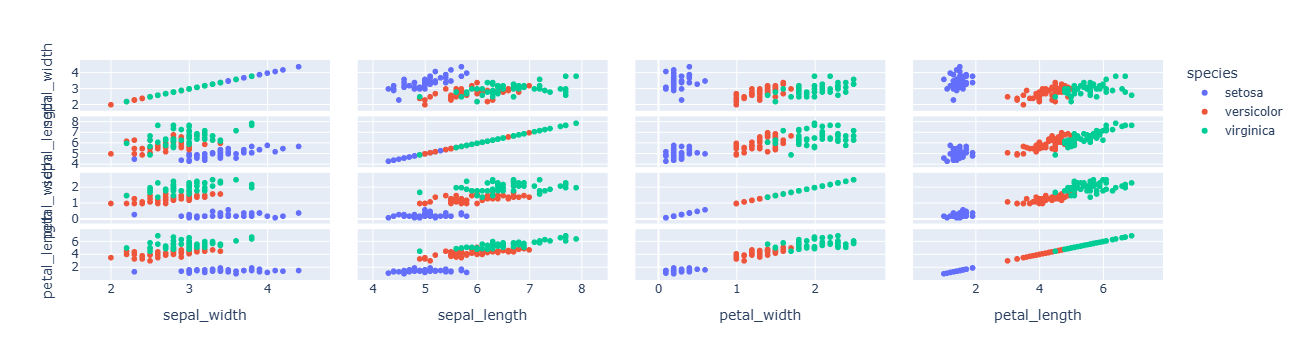

In [1]:
import plotly.express as px

df = px.data.iris()
features = ["sepal_width", "sepal_length", "petal_width", "petal_length"]
fig = px.scatter_matrix(df, dimensions=features, color="species")
fig.show()

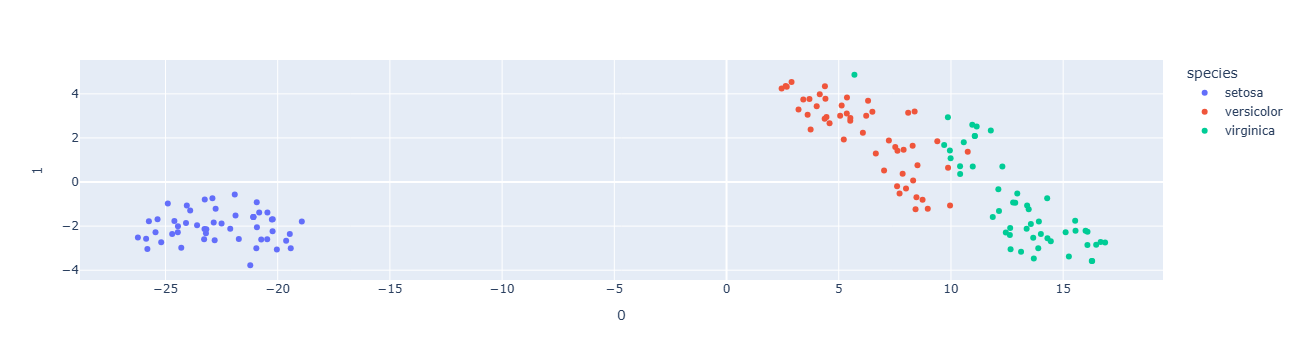

In [7]:
from sklearn.manifold import TSNE, trustworthiness
import plotly.express as px

df = px.data.iris()

features = df.loc[:, :'petal_width']

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(features)

fig = px.scatter(
    projections, x=0, y=1,
    color=df.species, labels={'color': 'species'}
)
fig.show()

In [8]:
score = trustworthiness(features.to_numpy(), projections, n_neighbors=5)
print(f'Trustworthiness score is: {score}')

Trustworthiness score is: 0.9880657276995305


C:\Users\Jonathan\anaconda3\envs\py313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



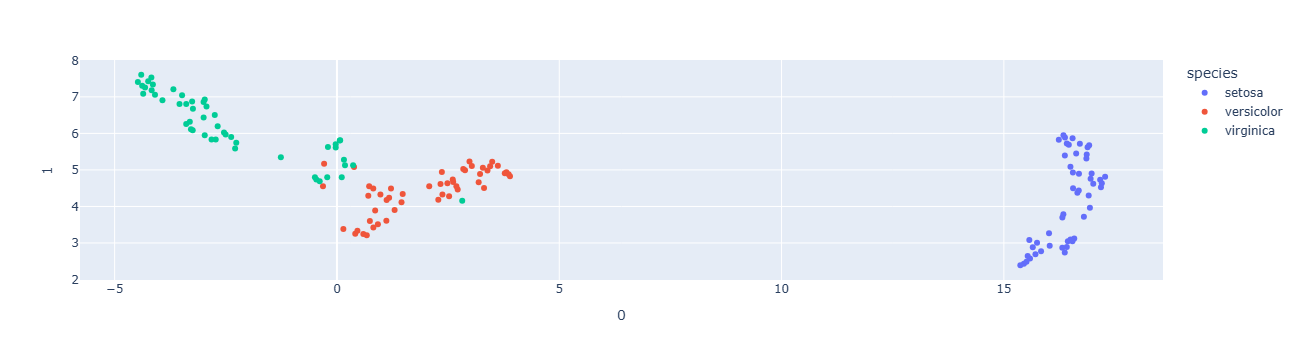

In [9]:
from umap import UMAP
import plotly.express as px

df = px.data.iris()

features = df.loc[:, :'petal_width']
umap_2d = UMAP(random_state=0, n_components=2)
umap_3d = UMAP(random_state=0, n_components=3, n_neighbors=5)
proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(proj_2d, x=0, y=1,
                 color=df.species, labels={'color': 'species'}
                )
fig_2d.show()


In [10]:
score = trustworthiness(features.to_numpy(), projections, n_neighbors=5)
print(f'Trustworthiness score is: {score}')

Trustworthiness score is: 0.9880657276995305
